# Set up

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import time

In [107]:
# 设置全局的字体大小和加粗 ### plt.rcParams
plt.rc('figure', figsize = [7,7])
plt.rc('font', size=20, weight='bold', family = 'Arial')  # 全局字体大小和加粗
plt.rc('axes', titlesize=20, titleweight='bold', titlepad = 15,
        labelpad=10, labelsize=18, labelweight='bold', linewidth = 1.2)  # 坐标轴标题和标签的字体
plt.rc('lines', linewidth = 2.2)
plt.rc('legend', framealpha = 0, loc = 'best')

plt.rc('xtick', labelsize=18, direction = 'in', top = True)  # x轴刻度标签字体大小
plt.rc('ytick', labelsize=18, direction = 'in', right = True)  # y轴刻度标签字体大小
plt.rc('xtick.major', size = 4, width = 2, pad = 4)  # x轴刻度线宽度
plt.rc('ytick.major', size = 4, width = 2, pad = 4)  # y轴刻度线宽度
plt.rc('xtick.minor', size = 2, width = 0.8, pad = 4)  # x轴刻度线宽度
plt.rc('ytick.minor', size = 2, width = 0.8, pad = 4)  # y轴刻度线宽度

## Structure

In [108]:
class DeviceStates:
    def __init__(
            self, 
            material_params = None, device_params = None, 
            electrical_params=None, physics_params=None, 
            math_params = None
    ):
        
        ### Define default parameters
        self.default_material_params = {

            'epsilon_FE': 24,  # FE background permittivity 
            'epsilon_IL': 3.9,  # Interfacial Layer Dielectric permittivity 
            'epsilon_Si': 11.7,  # Silicon permittivity
            'epsilon_Spacer': 6.3, # Spacer dielectric permittivity 
            'epsilon_Insulator': 1, # insulator dielectric permittivity 

            'N_donor': 1e17 *1e6,  # Drain Donor Doping concentration in m^-3
            'N_acceptor': 1e15 *1e6,  # Channel Acceptor Doping concentration in m^-3

            'mu_n': 0.14,  # electron mobility in m^2/V/s
            'mu_p': 0.041,  # hole mobility in m^2/V/s

            'N_c': 2.80e19 * 1e6,  # effective conduction band concentration in 1/m^3
            'N_v': 1.04e19 * 1e6,  # effective valance band concentration in 1/m^3
            'n_i': 6.80569e9 * 1e6,

            'E_g': 1.12,  # silicon bandgap in eV
            'E_d': -0.046,  # donor energy level under conduction band
            'E_a': 0.044,  # acceptor energy level under valence band
        }

        self.default_device_params = {

            'dz': 0.2e-9,  # Grid spacing in z-direction in m
            'dx': 1e-9, # Grid spacing in x-direction in m
            'Gate_length': 100e-9,  # MOSFET gate length in m
            'FE_thickness': 5e-9,  # FE thickness in m
            'DE_thickness': 1e-9,  # DE thickness in m
            'Si_thickness': 10e-9,  # Silicon channel thickness in m
            'Spacer_length': 25e-9, # spacer length in m
            'Insulator_Under_Si_thickness': 5e-9, # insulator under silicon thickness in m
            'Gate_drain_overlap_length': 4e-9, # gate / drain overlap length in m

        }

        self.default_electrical_params = {

            'V_Gate': 0,  # Gate Voltage
            'V_Drain': 0,  # Drain Voltage
            'V_Source': 0,  # Source Voltage
            'V_Substrate': 0,  # Substrate Voltage 
            'Is_Ground_Substrate': True, 

        }

        self.default_physics_params = {

            'epsilon_0': 8.854e-12,
            'k_B': 1.38e-23, 
            'T_0': 300, 
            'e_charge': 1.6e-19,
            'Use_Boltzmann_distribution': True, 
            'Use_Complete_ionization': True,

        }

        self.default_math_params = {
            'Gummel_Max_iter': 10, # Gummel Map maximum number of iterations
            'Gummel_tolerance': 1e-6, # Gummel Map tollerance
            'Poisson_Solver': 'Jacobi', 

            'Poisson_Jacobi_solver_tolerance': 1e-6,
            'Poisson_Jacobi_solver_max_step': 30000, 
            'Poisson_Jacobi_solver_omega_V': 1,

            'Poisson_Sparse_Matrix_max_update': 0.1, 

        }

        ### Update default parameters with any user-provided values
        if material_params:
            self.default_material_params.update(material_params)
        if device_params:
            self.default_device_params.update(device_params)
        if electrical_params:
            self.default_electrical_params.update(electrical_params)
        if physics_params:
            self.default_physics_params.update(physics_params)
        if math_params:
            self.default_math_params.update(math_params)
        
        ### initialize the device params and device physics variables and physics functions
        self.initialize_device_params()
        self.initialize_device_states()
        self.initialize_device_functions()

    def initialize_device_params(self):
        ###### Physics constant Parameters
        self.epsilon_0 = self.default_physics_params['epsilon_0']
        self.k_B = self.default_physics_params['k_B']
        self.T_0 = self.default_physics_params['T_0']
        self.e_charge = self.default_physics_params['e_charge']
        self.V_thermal = self.k_B * self.T_0 / self.e_charge
        self.Use_Boltzmann_distribution = self.default_physics_params['Use_Boltzmann_distribution']
        self.Use_Complete_ionization = self.default_physics_params['Use_Complete_ionization']

        # ### debug
        # self.Boltzmann = self.default_physics_params['Use_Boltzmann_distribution']

        ###### Device Material Parameters
        self.epsilon_FE = self.default_material_params['epsilon_FE']  # FE background permittivity 
        self.epsilon_IL = self.default_material_params['epsilon_IL']  # Interfacial Layer Dielectric permittivity 
        self.epsilon_Si = self.default_material_params['epsilon_Si']  # Silicon permittivity 
        self.epsilon_Spacer = self.default_material_params['epsilon_Spacer']  # Spacer dielectric permittivity 
        self.epsilon_Insulator = self.default_material_params['epsilon_Insulator']  # Spacer dielectric permittivity 
        
        self.N_donor = self.default_material_params['N_donor']  # Drain Donor Doping concentration in m^-3
        self.N_acceptor = self.default_material_params['N_acceptor']  # Channel Acceptor Doping concentration in m^-3
        self.mu_n = self.default_material_params['mu_n']  # electron mobility in m^2/V/s
        self.mu_p = self.default_material_params['mu_p']  # hole mobility in m^2/V/s

        self.N_c = self.default_material_params['N_c']
        self.N_v = self.default_material_params['N_v']
        self.n_i = self.default_material_params['n_i']
        self.E_g = self.default_material_params['E_g']

        self.delta_E_0 = 0.5 * self.k_B * self.T_0 / self.e_charge * np.log(self.N_c/ self.N_v)
        self.E_c = self.E_g/2 + self.delta_E_0
        self.E_v = -self.E_g/2 + self.delta_E_0

        self.E_d = self.E_c - self.default_material_params['E_d']
        self.E_a = self.E_v + self.default_material_params['E_a']


        ###### Device Structure Parameters
        self.dz = self.default_device_params['dz']  # Grid spacing in z-direction in m
        self.dx = self.default_device_params['dx']  # Grid spacing in x-direction in m
        self.Gate_length_meter = self.default_device_params['Gate_length']  # MOSFET gate length in m
        self.FE_thickness_meter = self.default_device_params['FE_thickness']  # FE thickness in m
        self.DE_thickness_meter = self.default_device_params['DE_thickness']  # DE thickness in m
        self.Si_thickness_meter = self.default_device_params['Si_thickness']  # Silicon channel thickness in m

        self.Gate_length_grid = int(self.Gate_length_meter/self.dx)
        self.FE_thickness_grid = int(self.FE_thickness_meter/self.dz)
        self.DE_thickness_grid = int(self.DE_thickness_meter/self.dz)
        self.Si_thickness_grid = int(self.Si_thickness_meter/self.dz)

        self.Spacer_length_meter = self.default_device_params['Spacer_length'] # spacer length in m
        self.Insulator_Under_Si_thickness_meter = self.default_device_params['Insulator_Under_Si_thickness'] # insulator under silicon thickness in m
        self.Spacer_length_grid = int(self.Spacer_length_meter/self.dx) 
        self.Insulator_thickness_grid = int(self.Insulator_Under_Si_thickness_meter/self.dz) 

        self.Gate_drain_overlap_meter = self.default_device_params['Gate_drain_overlap_length'] # extended source / drain region length into channel in m
        self.Gate_drain_overlap_grid = int(self.Gate_drain_overlap_meter/self.dx)
        

        ###### Device Electrical Parameters
        self.V_G = self.default_electrical_params['V_Gate']  # Gate Voltage
        self.V_D = self.default_electrical_params['V_Drain']  # Drain Voltage
        self.V_S = self.default_electrical_params['V_Source']  # Source Voltage
        self.V_B = self.default_electrical_params['V_Substrate']  # Substrate Voltage    
        self.Is_Ground_Substrate = self.default_electrical_params['Is_Ground_Substrate']


        ###### Simulation Math Parameters   
        self.Gummel_Max_iter = self.default_math_params['Gummel_Max_iter']
        self.Gummel_tolerance = self.default_math_params['Gummel_tolerance']
        self.Poisson_Solver = self.default_math_params['Poisson_Solver']
        
        self.Poisson_Jacobi_solver_tolerance = self.default_math_params['Poisson_Jacobi_solver_tolerance']
        self.Poisson_Jacobi_solver_max_step = self.default_math_params['Poisson_Jacobi_solver_max_step']
        self.Poisson_Jacobi_solver_omega_V = self.default_math_params['Poisson_Jacobi_solver_omega_V']

        self.Poisson_Sparse_Matrix_max_update = self.default_math_params['Poisson_Sparse_Matrix_max_update'] 

    def initialize_device_states(self):
        
        ### SOI channel doping profile
        self.donor_profile = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1))
        self.acceptor_profile = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1))

        self.acceptor_profile[
            self.Spacer_length_grid + self.Gate_drain_overlap_grid: self.Spacer_length_grid + self.Gate_length_grid - self.Gate_drain_overlap_grid + 1, 
                              1:-1
        ] = self.N_acceptor

        self.donor_profile[:, 1:-1] = self.N_donor
        self.donor_profile[
            self.Spacer_length_grid + self.Gate_drain_overlap_grid: self.Spacer_length_grid + self.Gate_length_grid - self.Gate_drain_overlap_grid + 1, 
            :
        ] = 0


        ### physics variable arrays initialization
        self.V_grid = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Insulator_thickness_grid + self.FE_thickness_grid + self.DE_thickness_grid + self.Si_thickness_grid + self.Insulator_thickness_grid +1))
        self.Q0 = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Insulator_thickness_grid + self.FE_thickness_grid + self.DE_thickness_grid + self.Si_thickness_grid + self.Insulator_thickness_grid +1))

        self.Epsilon =self.epsilon_Insulator * np.ones((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid, self.Insulator_thickness_grid + self.FE_thickness_grid + self.DE_thickness_grid + self.Si_thickness_grid + self.Insulator_thickness_grid))
        self.Pz = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid, self.Insulator_thickness_grid + self.FE_thickness_grid + self.DE_thickness_grid + self.Si_thickness_grid + self.Insulator_thickness_grid))

        self.Epsilon[:, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, 0:self.Si_thickness_grid] = self.epsilon_Si 
        self.Epsilon[:, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, self.Si_thickness_grid:] = self.epsilon_Spacer 
        self.Epsilon[self.Spacer_length_grid: -self.Spacer_length_grid, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, self.Si_thickness_grid: self.Si_thickness_grid+ self.DE_thickness_grid] = self.epsilon_IL
        self.Epsilon[self.Spacer_length_grid: -self.Spacer_length_grid, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, self.Si_thickness_grid + self.DE_thickness_grid: ] = self.epsilon_FE


        ### initial Polarization distribution
        Pr0 = 10e-2  # C/m^2
        self.Pz[self.Spacer_length_grid: -self.Spacer_length_grid, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:,self.DE_thickness_grid + self.Si_thickness_grid:] = Pr0 * 0.1 * (2*np.random.rand(self.Gate_length_grid, self.FE_thickness_grid) -1)
        self.Pz0 = self.Pz.copy()


        ### quasi fermi level initialization
        self.phi_n = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1)) - self.V_thermal * np.log(self.N_donor/self.n_i)
        # self.phi_p = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1)) 
        self.phi_p  = self.phi_n.copy()  ### a good initial guess could make the solver faster

        ### initial carrier concentration
        self.hole_concentration = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1))
        self.electron_concentration = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1))

    def initialize_device_functions(self):
        
        if self.Use_Boltzmann_distribution == True:
            self._electron_concentration_func = self._electron_concentration_Boltzmann_func
            self._hole_concentration_func = self._hole_concentration_Boltzmann_func
        else:
            self._electron_concentration_func = self._electron_concentration_Fermi_Dirac_func
            self._hole_concentration_func = self._hole_concentration_Fermi_Dirac_func

        if self.Use_Complete_ionization == True:
            self._net_dopant_concentration = self._complete_ionized_dopant_concentration
        else:
            self._net_dopant_concentration = self._incomplete_ionized_dopant_concentration


    def update_device_parameters(
                        self, 
            material_params = None, device_params = None, 
            electrical_params=None, physics_params=None, 
            math_params = None
    ):
        
        # Update default parameters with any user-provided values
        if material_params:
            self.default_material_params.update(material_params)
        if device_params:
            self.default_device_params.update(device_params)
        if electrical_params:
            self.default_electrical_params.update(electrical_params)
        if physics_params:
            self.default_physics_params.update(physics_params)
        if math_params:
            self.default_math_params.update(math_params)
        
        self.initialize_device_params()

    ### Semiconductor charge density calculation part starts here  ###
    ###### mathematical function for calculating the charge density
    def _FD_half(x):
        
        '''
        Following: http://dx.doi.org/10.1063/1.4825209
        '''

        v = x**4 + 50 + 33.6 * x * (1 - 0.68 * np.exp(-0.17 * (x+1)**2))
        return 1 / ( np.exp(-x) + 3 * np.pi**0.5 / 4 * v**(-3/8) )

    def _electron_concentration_Boltzmann_func(self, phi, phi_n = 0):
 
        return self.N_c * np.exp(
            np.clip(
                (phi - self.E_c - phi_n)/self.V_thermal, a_min= -40, a_max= 3,
            )
        )  
        
    def _electron_concentration_Fermi_Dirac_func(self, phi, phi_n = 0):

        return self.N_c * self._FD_half((phi - self.E_c - phi_n)/self.V_thermal)    

    def _hole_concentration_Boltzmann_func(self, phi, phi_p=0):

        return self.N_v * np.exp(
            np.clip(
                (self.E_v - phi + phi_p)/self.V_thermal, a_min= -40, a_max= 3,
            )
        )  

    def _hole_concentration_Fermi_Dirac_func(self, phi, phi_p=0):

        return self.N_v * self._FD_half((self.E_v - phi + phi_p)/self.V_thermal)

    def _complete_ionized_dopant_concentration(self): ### (N_D - N_A)    
        return self.donor_profile - self.acceptor_profile

    def _incomplete_ionized_dopant_concentration(self):
        '''
        incomplete ionized dopant concentration calculation 
        '''

        phi = self.V_grid[:, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, 0:self.Si_thickness_grid+1].copy() + 1e-8

        return self.donor_profile * 1/(1 + 2 * np.exp((phi - self.E_d - self.phi_n)/self.V_thermal)) - \
            self.acceptor_profile * 1/(1 + 4 * np.exp((self.E_a - phi + self.phi_p)/self.V_thermal))

    def _charge_density_func(self, phi, phi_n = 0, phi_p=0):

        dopants = self._net_dopant_concentration()

        if (phi.shape != dopants.shape):
            raise ValueError(
                f"--- Error: phi matrix shape {phi.shape} should be equal to dopoing profile matrix shape {dopants.shape}! ---"
                )   
        
        electrons = self._electron_concentration_func(phi, phi_n)
        holes = self._hole_concentration_func(phi, phi_p)
 
        SC_Q = self.e_charge * (holes - electrons + dopants)
        
        return SC_Q

    def charge_density(self):
        return self.e_charge * (self.hole_concentration - self.electron_concentration + self._net_dopant_concentration())
        

## Simulator

--- Starting Newton Solver for 2D Problem ---


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Converged in 2 iterations.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

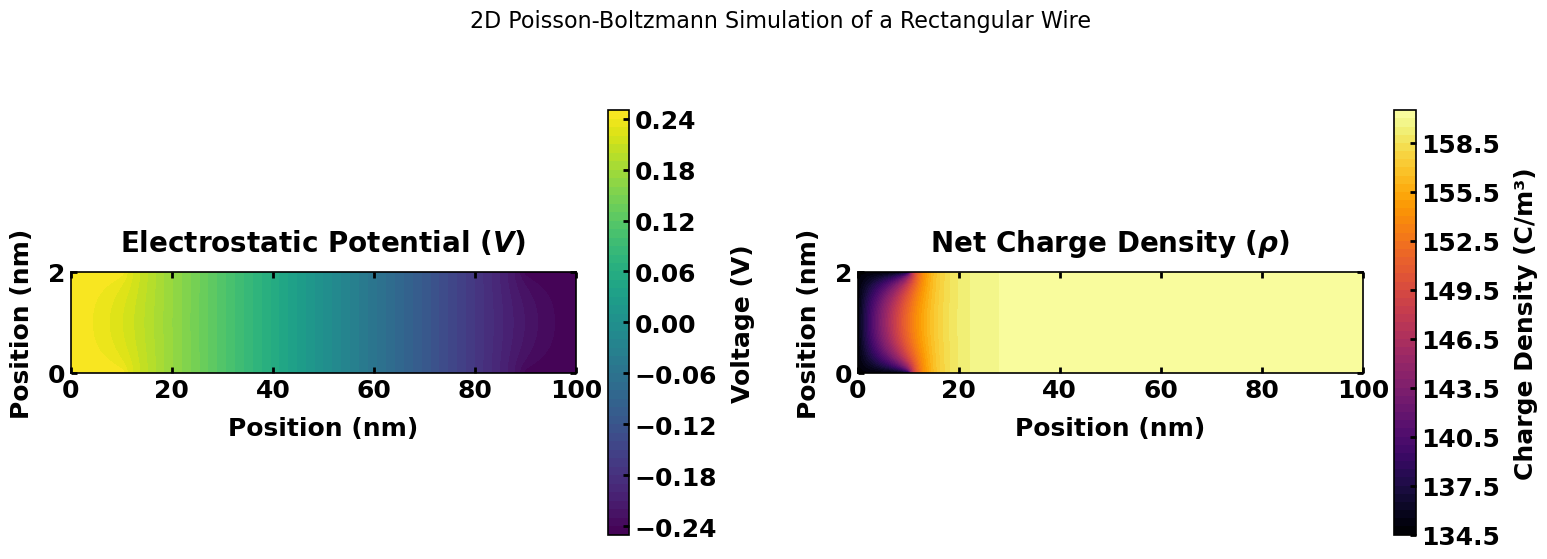

In [109]:
import dolfinx
import dolfinx.fem.petsc
import dolfinx.nls.petsc
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc

import matplotlib.pyplot as plt
import matplotlib.tri as tri

# --- Physical Constants
q = 1.602e-19       # Elementary charge (C)
k_B = 1.380e-23     # Boltzmann constant (J/K)
T = 300.0           # Temperature (K)
epsilon_0 = 8.854e-12 # Vacuum permittivity (F/m)
epsilon_r = 11.7      # Relative permittivity of Silicon
eps = epsilon_r * epsilon_0
n_i = 1.0e16          # Intrinsic carrier concentration in Si (m^-3)
N_D = 1.0e21          # Donor doping concentration (m^-3)
thermal_voltage = k_B * T / q

# --- 2D Geometry Definition
device_length = 100e-9 # Length in x-direction (m)
device_width = 20e-9   # Width in y-direction (m)
mesh_size_x = 200      # Number of elements in x
mesh_size_y = 40       # Number of elements in y

# --- Create a 2D Rectangular Mesh
mesh = dolfinx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([device_length, device_width])],
    [mesh_size_x, mesh_size_y],
    cell_type=dolfinx.mesh.CellType.triangle
)
V_space = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

# --- Custom Nonlinear Problem Class (No changes needed)
class PoissonBoltzmannProblem(dolfinx.fem.petsc.NonlinearProblem):
    """Custom class for the nonlinear Poisson-Boltzmann problem."""
    def __init__(self, F, J, u, rho, drho_dv, bcs):
        super().__init__(F, u, bcs=bcs, J=J)
        self._rho = rho
        self._drho_dv = drho_dv
        self._u = u

    def F(self, x: PETSc.Vec, b: PETSc.Vec):
        """Assemble the residual vector F(x, b)."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self._u.x.petsc_vec)
        self._u.x.scatter_forward()

        potential_values = self._u.x.array
        self._rho.x.array[:] = q * (N_D - n_i * np.exp(potential_values / thermal_voltage))
        self._rho.x.scatter_forward()
        
        with b.localForm() as b_loc:
            b_loc.set(0)
        dolfinx.fem.petsc.assemble_vector(b, self._L)
        dolfinx.fem.apply_lifting(b, [self._a], [self.bcs], [x], -1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        dolfinx.fem.set_bc(b, self.bcs, x, -1.0)


    def J(self, x: PETSc.Vec, A: PETSc.Mat):
        """Assemble the Jacobian matrix J(x, A)."""
        potential_values = self._u.x.array
        self._drho_dv.x.array[:] = -q * (n_i / thermal_voltage) * np.exp(potential_values / thermal_voltage)
        self._drho_dv.x.scatter_forward()
        
        A.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(A, self._a, self.bcs)
        A.assemble()

# --- UFL Formulation (No changes needed for 2D)
Vh = dolfinx.fem.Function(V_space, name="Potential")
rho_h = dolfinx.fem.Function(V_space, name="ChargeDensity")
d_rho_dV_h = dolfinx.fem.Function(V_space, name="ChargeDensityDerivative")

v = ufl.TestFunction(V_space)
# The term rho_h must be on the LHS for the derivative to be computed correctly
F = eps * ufl.dot(ufl.grad(Vh), ufl.grad(v)) * ufl.dx + rho_h * v * ufl.dx
J = ufl.derivative(F, Vh, ufl.TrialFunction(V_space))

# --- Boundary Conditions
V_S = 0.25  # Source voltage on the left
V_D = -0.25 # Drain voltage on the right

# Helper functions to locate boundaries
def left_boundary(x):
    return np.isclose(x[0], 0)

def right_boundary(x):
    return np.isclose(x[0], device_length)

# NOTE: Top and bottom have zero Neumann conditions (dV/dn = 0), which are
# natural boundary conditions in this formulation. They are satisfied automatically
# if we don't specify any other condition on those boundaries.

fdim = mesh.topology.dim - 1 # fdim = 1 for edges in a 2D mesh
left_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, left_boundary)
right_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, right_boundary)

left_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, left_facets)
right_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, right_facets)

bc_left = dolfinx.fem.dirichletbc(PETSc.ScalarType(V_S), left_dofs, V_space)
bc_right = dolfinx.fem.dirichletbc(PETSc.ScalarType(V_D), right_dofs, V_space)
bcs = [bc_left, bc_right]

# --- Setup Solver
problem = dolfinx.fem.petsc.NonlinearProblem(F, Vh, bcs=bcs, J=J)

solver = dolfinx.nls.petsc.NewtonSolver(mesh.comm, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.max_it = 50

# Configure solver options
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps" # Use a robust direct solver
ksp.setFromOptions()

# --- Initial Guess and Solve
# Linear interpolation between source and drain voltage
Vh.interpolate(lambda x: V_S + (V_D - V_S) * x[0] / device_length)

print("--- Starting Newton Solver for 2D Problem ---")
n, converged = solver.solve(Vh)
if converged:
    print(f"Converged in {n} iterations.")
else:
    print(f"Solver did not converge in {n} iterations.")

# --- Post-Processing and Visualization
if MPI.COMM_WORLD.rank == 0:
    # Get coordinates and solution values for plotting
    coords = V_space.tabulate_dof_coordinates()
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    
    # Update the charge density function 'rho_h' with the final potential
    potential_values = Vh.x.array
    rho_h.x.array[:] = q * (N_D - n_i * np.exp(potential_values / thermal_voltage))
    rho_values = rho_h.x.array
    
    # Create triangulation for plotting
    triangulation = tri.Triangulation(x_coords, y_coords)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('2D Poisson-Boltzmann Simulation of a Rectangular Wire', fontsize=16)

    # Plot Electrostatic Potential
    contour1 = ax1.tricontourf(triangulation, Vh.x.array, levels=50, cmap='viridis')
    fig.colorbar(contour1, ax=ax1, label='Voltage (V)')
    ax1.set_title("Electrostatic Potential ($V$)")
    ax1.set_xlabel("Position (nm)")
    ax1.set_ylabel("Position (nm)")
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_xticklabels([f'{x*1e9:.0f}' for x in ax1.get_xticks()])
    ax1.set_yticklabels([f'{y*1e9:.0f}' for y in ax1.get_yticks()])


    # Plot Charge Density
    contour2 = ax2.tricontourf(triangulation, rho_values, levels=50, cmap='inferno')
    fig.colorbar(contour2, ax=ax2, label='Charge Density (C/m³)')
    ax2.set_title("Net Charge Density ($\\rho$)")
    ax2.set_xlabel("Position (nm)")
    ax2.set_ylabel("Position (nm)")
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_xticklabels([f'{x*1e9:.0f}' for x in ax2.get_xticks()])
    ax2.set_yticklabels([f'{y*1e9:.0f}' for y in ax2.get_yticks()])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
import dolfinx
import dolfinx.fem.petsc
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from scipy.interpolate import RegularGridInterpolator
import math

# ---------------------------------------------------------------------------
# Helper numerical utilities
# ---------------------------------------------------------------------------

def bernoulli(x):
    """Stable Bernoulli function B(x) = x / (exp(x)-1).
    Uses series expansion for small |x| to avoid loss of significance."""
    out = np.zeros_like(x)
    small = np.abs(x) < 1e-6
    xs = x[small]
    out[small] = 1 - xs/2 + xs**2/12 - xs**4/720  # series up to x^4
    large = ~small
    xl = x[large]
    out[large] = xl / (np.exp(xl) - 1.0)
    return out

# ---------------------------------------------------------------------------
# Linear Poisson assembler (Gummel) with optional full Newton
# ---------------------------------------------------------------------------
class PoissonAssembler:
    """Handles Poisson assembly with updated charge density.

    Modes:
      - linear_gummel: treat n, p fixed; solve linear Poisson.
      - newton: include carrier derivatives for coupled Newton (optional).
    """
    def __init__(self, device_state, V_space, Q_space, epsilon_h, mode="linear_gummel"):
        self.ds = device_state
        self.V_space = V_space
        self.Q_space = Q_space
        self.epsilon_h = epsilon_h
        self.mode = mode

        self.Vh = dolfinx.fem.Function(V_space, name="Potential")
        self.rho_h = dolfinx.fem.Function(Q_space, name="ChargeDensity")  # cell-wise charge
        self.drho_dV_h = dolfinx.fem.Function(V_space, name="dRho_dV")     # only used in Newton mode

        self.v = ufl.TestFunction(V_space)
        self.u_trial = ufl.TrialFunction(V_space)

        # Build stiffness (independent of V as permittivity fixed)
        self.a_stiff = self.epsilon_h * ufl.dot(ufl.grad(self.u_trial), ufl.grad(self.v)) * ufl.dx

        # Precompute cell midpoints & silicon mask for vectorised charge mapping
        mesh = V_space.mesh
        tdim = mesh.topology.dim
        num_cells_local = mesh.topology.index_map(tdim).size_local
        self._cell_indices = np.arange(num_cells_local, dtype=np.int32)
        self.midpoints = dolfinx.mesh.compute_midpoints(mesh, tdim, self._cell_indices)
        z = self.midpoints[:, 1]
        ds = self.ds
        self.si_mask = (z >= ds.Insulator_Under_Si_thickness_meter) & (z <= ds.Insulator_Under_Si_thickness_meter + ds.Si_thickness_meter)
        # Build structured-grid interpolators for n, p, dopants, quasi-Fermi levels
        Nx_si, Nz_si = ds.electron_concentration.shape
        self.x_axis_si = np.linspace(0, (Nx_si - 1) * ds.dx, Nx_si)
        self.z_axis_si = np.linspace(ds.Insulator_Under_Si_thickness_meter,
                                     ds.Insulator_Under_Si_thickness_meter + (Nz_si - 1) * ds.dz, Nz_si)
        self._grid_axes = (self.x_axis_si, self.z_axis_si)
        # Map reuse for structured grid export
        self._cache_map = None

        def build_interp(arr, fill=0):
            return RegularGridInterpolator(self._grid_axes, arr, method='linear', bounds_error=False, fill_value=fill)

        self.n_interp = build_interp(ds.electron_concentration, fill=ds.n_i)
        self.p_interp = build_interp(ds.hole_concentration, fill=ds.n_i)
        self.donor_interp = build_interp(ds.donor_profile, fill=0.0)
        self.acceptor_interp = build_interp(ds.acceptor_profile, fill=0.0)
        self.phin_interp = build_interp(ds.phi_n, fill=0.0)
        self.phip_interp = build_interp(ds.phi_p, fill=0.0)

        # Map reuse for structured grid export
        self._cache_map = None

    # ----------------------------- Charge Update ----------------------------
# ...existing code...
    def update_charge(self):
        ds = self.ds
        V_th = ds.V_thermal

        # Evaluate potential at cell midpoints
        potential_vals = self.Vh.eval(self.midpoints, self._cell_indices).squeeze()

        # Interpolation points (x,z) inside silicon only
        mid_si = self.midpoints[self.si_mask]
        if mid_si.size == 0:
            self.rho_h.x.array[:] = 0.0
            self.rho_h.x.scatter_forward()
            return

        pts_si = np.vstack((mid_si[:, 0], mid_si[:, 1])).T

        # Rebuild interpolators with current arrays (avoids stale charge)
        from scipy.interpolate import RegularGridInterpolator
        n_interp   = RegularGridInterpolator(self._grid_axes, ds.electron_concentration, bounds_error=False, fill_value=ds.n_i)
        p_interp   = RegularGridInterpolator(self._grid_axes, ds.hole_concentration,     bounds_error=False, fill_value=ds.n_i)
        Nd_interp  = RegularGridInterpolator(self._grid_axes, ds.donor_profile,          bounds_error=False, fill_value=0.0)
        Na_interp  = RegularGridInterpolator(self._grid_axes, ds.acceptor_profile,       bounds_error=False, fill_value=0.0)
        phin_interp= RegularGridInterpolator(self._grid_axes, ds.phi_n,                   bounds_error=False, fill_value=0.0)
        phip_interp= RegularGridInterpolator(self._grid_axes, ds.phi_p,                   bounds_error=False, fill_value=0.0)

        n_si  = n_interp(pts_si)
        p_si  = p_interp(pts_si)
        Nd    = Nd_interp(pts_si)
        Na    = Na_interp(pts_si)
        phin  = phin_interp(pts_si)
        phip  = phip_interp(pts_si)

        # Stable dopant ionization
        Vsi   = potential_vals[self.si_mask]
        arg_d = np.clip((Vsi - ds.E_d - phin) / V_th, -50.0, 50.0)
        arg_a = np.clip((ds.E_a - Vsi + phip) / V_th, -50.0, 50.0)
        exp_d = np.exp(arg_d)
        exp_a = np.exp(arg_a)
        ionized_d = Nd / (1.0 + 2.0 * exp_d)
        ionized_a = Na / (1.0 + 4.0 * exp_a)

        rho = np.zeros_like(potential_vals)
        rho[self.si_mask] = ds.e_charge * (p_si - n_si + ionized_d - ionized_a)

        # Assign to DG0 cell function
        rho = np.nan_to_num(rho, copy=False)
        self.rho_h.x.array[:] = rho
        self.rho_h.x.scatter_forward()

        if self.mode == "newton":
            dNd_dV = -Nd * (2.0 * exp_d) / (V_th * (1.0 + 2.0 * exp_d) ** 2)
            dNa_dV =  Na * (4.0 * exp_a) / (V_th * (1.0 + 4.0 * exp_a) ** 2)
            dn_dV  = -n_si / V_th
            dp_dV  =  p_si / V_th
            drho_dV_si = ds.e_charge * (dp_dV - dn_dV + dNd_dV - dNa_dV)
            avg = float(np.mean(drho_dV_si)) if drho_dV_si.size > 0 else 0.0
            self.drho_dV_h.x.array[:] = avg
            self.drho_dV_h.x.scatter_forward()
# ...existing code...
    # ----------------------------- Poisson Solve ---------------------------
    def solve_poisson(self, bcs, damping=0.5):
        self.update_charge()
        L = - self.rho_h * self.v * ufl.dx
        A = dolfinx.fem.petsc.assemble_matrix(dolfinx.fem.form(self.a_stiff), bcs)
        A.assemble()
        b = dolfinx.fem.petsc.assemble_vector(dolfinx.fem.form(L))
        dolfinx.fem.apply_lifting(b, [dolfinx.fem.form(self.a_stiff)], [bcs])
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        dolfinx.fem.set_bc(b, bcs)
        ksp = PETSc.KSP().create(A.comm)
        ksp.setOperators(A)
        ksp.setType(PETSc.KSP.Type.PREONLY)
        pc = ksp.getPC()
        pc.setType(PETSc.PC.Type.LU)
        pc.setFactorSolverType("mumps")
        ksp.setUp()
        # PETSc vector of Function
        uh_vec = self.Vh.x.petsc_vec.duplicate()
        ksp.solve(b, uh_vec)
        # Under-relaxation into existing vector
        self.Vh.x.array[:] = (1 - damping) * self.Vh.x.array + damping * uh_vec.array
        self.Vh.x.scatter_forward()

    # ----------------------------- Mapping to NumPy ------------------------
# ...existing code...
    def map_to_numpy(self):
        ds = self.ds
        Nx, Nz = ds.V_grid.shape
        Lx = (Nx - 1) * ds.dx
        Ly = (Nz - 1) * ds.dz

        # Potential mapping cache
        x_coords = np.linspace(0, Lx, Nx)
        z_coords = np.linspace(0, Ly, Nz)
        xx, zz = np.meshgrid(x_coords, z_coords, indexing='ij')
        points = np.vstack((xx.ravel(), zz.ravel(), np.zeros(xx.size))).T
        if self._cache_map is None:
            mesh = self.V_space.mesh
            tdim = mesh.topology.dim
            tree = dolfinx.geometry.bb_tree(mesh, tdim)
            candidates = dolfinx.geometry.compute_collisions_points(tree, points)
            colliding = dolfinx.geometry.compute_colliding_cells(mesh, candidates, points)
            cells = []
            inside_pts = []
            map_idx = np.full(len(points), -1, dtype=int)
            for i in range(len(points)):
                links = colliding.links(i)
                if len(links) > 0:
                    cells.append(links[0])
                    inside_pts.append(points[i])
                    map_idx[i] = len(inside_pts) - 1
            self._cache_map = {
                'cells': np.array(cells, dtype=np.int32),
                'inside_pts': np.array(inside_pts, dtype=self.V_space.mesh.geometry.x.dtype),
                'map_idx': map_idx,
                'shape': (Nx, Nz),
            }

        # Potential mapping
        cache = self._cache_map
        pot_inside = self.Vh.eval(cache['inside_pts'], cache['cells']).squeeze()
        pot_flat = np.zeros(len(points))
        valid = cache['map_idx'] >= 0
        pot_flat[valid] = pot_inside[cache['map_idx'][valid]]
        ds.V_grid[:] = pot_flat.reshape(cache['shape'])

        # Charge for monitoring/plots from current carriers (structured grid)
        j0 = ds.Insulator_thickness_grid
        js = ds.Si_thickness_grid
        ds.Q0.fill(0.0)
        rho_si = ds.e_charge * (ds.hole_concentration - ds.electron_concentration + ds._net_dopant_concentration())
        ds.Q0[:, j0:j0+js+1][:, 1:js] = rho_si[:, 1:js]
# ...existing code...
# ---------------------------------------------------------------------------
# Continuity Equations (Scharfetter–Gummel) on structured grid
# ---------------------------------------------------------------------------
class ContinuitySolver:
    def __init__(self, device_state):
        self.ds = device_state

# ...existing code...
    def solve_electron(self):
        ds = self.ds
        V_si = ds.V_grid[:, ds.Insulator_thickness_grid: -ds.Insulator_thickness_grid][:, 1:ds.Si_thickness_grid]
        Nx_si, Nz_si = V_si.shape
        Vt = ds.V_thermal
        dVx = (V_si[1:, :] - V_si[:-1, :]) / Vt
        dVz = (V_si[:, 1:] - V_si[:, :-1]) / Vt
        Bp_x = bernoulli(dVx); Bn_x = bernoulli(-dVx)
        Bp_z = bernoulli(dVz); Bn_z = bernoulli(-dVz)
        rows = []; cols = []; data = []; b = []
        def idx(i,j): return i + j * Nx_si
        for i in range(Nx_si):
            for j in range(Nz_si):
                row = idx(i,j)
                if i == 0 or i == Nx_si-1:
                    rows.append(row); cols.append(row); data.append(1.0); b.append(ds.N_donor); continue
                coeff_center = 0.0; rhs = 0.0
                coeff_center += (Bp_x[i-1,j] + Bn_x[i,j])
                rows.append(row); cols.append(idx(i-1,j)); data.append(-Bp_x[i-1,j])
                rows.append(row); cols.append(idx(i+1,j)); data.append(-Bn_x[i,j])
                if j>0:
                    coeff_center += Bp_z[i,j-1]; rows.append(row); cols.append(idx(i,j-1)); data.append(-Bp_z[i,j-1])
                if j<Nz_si-1:
                    coeff_center += Bn_z[i,j]; rows.append(row); cols.append(idx(i,j+1)); data.append(-Bn_z[i,j])
                rows.append(row); cols.append(row); data.append(coeff_center); b.append(rhs)
        A = sp.csr_matrix((data,(rows,cols)), shape=(Nx_si*Nz_si, Nx_si*Nz_si))
        n_vec = spla.spsolve(A, np.array(b))
        n_grid = n_vec.reshape((Nx_si, Nz_si))
        n_grid = np.clip(n_grid, 1.0, None)  # positivity
        alpha = 0.2
        old = ds.electron_concentration[:,1:1+Nz_si].copy()
        ds.electron_concentration[:,1:1+Nz_si] = (1-alpha)*old + alpha*n_grid
        ds.phi_n[:,1:1+Nz_si] = V_si - np.log(np.maximum(ds.electron_concentration[:,1:1+Nz_si],1.0)/ds.n_i)*Vt

    def solve_hole(self):
        ds = self.ds
        V_si = ds.V_grid[:, ds.Insulator_thickness_grid: -ds.Insulator_thickness_grid][:, 1:ds.Si_thickness_grid]
        Nx_si, Nz_si = V_si.shape
        Vt = ds.V_thermal
        dVx = (V_si[1:, :] - V_si[:-1, :]) / Vt
        dVz = (V_si[:, 1:] - V_si[:, :-1]) / Vt
        Bp_x = bernoulli(-dVx); Bn_x = bernoulli(dVx)
        Bp_z = bernoulli(-dVz); Bn_z = bernoulli(dVz)
        rows = []; cols = []; data = []; b = []
        def idx(i,j): return i + j * Nx_si
        for i in range(Nx_si):
            for j in range(Nz_si):
                row = idx(i,j)
                if i == 0 or i == Nx_si-1:
                    rows.append(row); cols.append(row); data.append(1.0); b.append(ds.n_i**2/ds.N_donor); continue
                coeff_center = 0.0; rhs = 0.0
                coeff_center += (Bp_x[i-1,j] + Bn_x[i,j])
                rows.append(row); cols.append(idx(i-1,j)); data.append(-Bp_x[i-1,j])
                rows.append(row); cols.append(idx(i+1,j)); data.append(-Bn_x[i,j])
                if j>0:
                    coeff_center += Bp_z[i,j-1]; rows.append(row); cols.append(idx(i,j-1)); data.append(-Bp_z[i,j-1])
                if j<Nz_si-1:
                    coeff_center += Bn_z[i,j]; rows.append(row); cols.append(idx(i,j+1)); data.append(-Bn_z[i,j])
                rows.append(row); cols.append(row); data.append(coeff_center); b.append(rhs)
        A = sp.csr_matrix((data,(rows,cols)), shape=(Nx_si*Nz_si, Nx_si*Nz_si))
        p_vec = spla.spsolve(A, np.array(b))
        p_grid = p_vec.reshape((Nx_si, Nz_si))
        p_grid = np.clip(p_grid, 1.0, None)
        alpha = 0.2
        old = ds.hole_concentration[:,1:1+Nz_si].copy()
        ds.hole_concentration[:,1:1+Nz_si] = (1-alpha)*old + alpha*p_grid
        ds.phi_p[:,1:1+Nz_si] = V_si + np.log(np.maximum(ds.hole_concentration[:,1:1+Nz_si],1.0)/ds.n_i)*Vt
# ...existing code...
# High-level FEM Simulator orchestrating Gummel iterations
# ---------------------------------------------------------------------------
class FEM_Simulator:
    def __init__(self, device_state):
        self.device_state = device_state

    def solve_device_state(self, mesh_size_x=200, mesh_size_y=150, gummel_max=None, gummel_tol=None, use_newton=False):
        ds = self.device_state
        if gummel_max is None: gummel_max = ds.Gummel_Max_iter
        if gummel_tol is None: gummel_tol = ds.Gummel_tolerance
        Nx, Nz = ds.V_grid.shape
        Lx = (Nx - 1) * ds.dx
        Ly = (Nz - 1) * ds.dz
        mesh = dolfinx.mesh.create_rectangle(MPI.COMM_WORLD,
                                             [np.array([0,0]), np.array([Lx, Ly])],
                                             [mesh_size_x, mesh_size_y],
                                             cell_type=dolfinx.mesh.CellType.triangle)
        V_space = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))
        Q_space = dolfinx.fem.functionspace(mesh, ("DG", 0))
        epsilon_h = dolfinx.fem.Function(V_space)
        ins_thick = ds.Insulator_Under_Si_thickness_meter
        si_thick = ds.Si_thickness_meter
        de_thick = ds.DE_thickness_meter
        fe_thick = ds.FE_thickness_meter
        spacer_len = ds.Spacer_length_meter
        gate_len = ds.Gate_length_meter
        def epsilon_profile(x):
            eps = np.full(x.shape[1], ds.epsilon_Insulator * ds.epsilon_0)
            si_mask = (x[1] >= ins_thick) & (x[1] <= ins_thick + si_thick)
            eps[si_mask] = ds.epsilon_Si * ds.epsilon_0
            spacer_mask = (x[1] > ins_thick + si_thick)
            eps[spacer_mask] = ds.epsilon_Spacer * ds.epsilon_0
            de_mask = (x[0] >= spacer_len) & (x[0] <= spacer_len + gate_len) & (x[1] > ins_thick + si_thick) & (x[1] <= ins_thick + si_thick + de_thick)
            eps[de_mask] = ds.epsilon_IL * ds.epsilon_0
            fe_mask = (x[0] >= spacer_len) & (x[0] <= spacer_len + gate_len) & (x[1] > ins_thick + si_thick + de_thick) & (x[1] <= ins_thick + si_thick + de_thick + fe_thick)
            eps[fe_mask] = ds.epsilon_FE * ds.epsilon_0
            return eps
        epsilon_h.interpolate(epsilon_profile)
        source_ymin = ins_thick; source_ymax = ins_thick + si_thick
        gate_x_min = spacer_len; gate_x_max = spacer_len + gate_len
        gate_y = ins_thick + si_thick + de_thick + fe_thick
        def source_boundary(x): return np.isclose(x[0], 0) & (x[1] >= source_ymin) & (x[1] <= source_ymax)
        def drain_boundary(x): return np.isclose(x[0], Lx) & (x[1] >= source_ymin) & (x[1] <= source_ymax)
        def gate_boundary(x): return np.isclose(x[1], gate_y) & (x[0] >= gate_x_min) & (x[0] <= gate_x_max)
        def substrate_boundary(x): return np.isclose(x[1], 0)
        fdim = mesh.topology.dim - 1
        bcs = []
        source_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, source_boundary)
        source_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, source_facets)
        bcs.append(dolfinx.fem.dirichletbc(PETSc.ScalarType(ds.V_S), source_dofs, V_space))
        drain_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, drain_boundary)
        drain_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, drain_facets)
        bcs.append(dolfinx.fem.dirichletbc(PETSc.ScalarType(ds.V_D), drain_dofs, V_space))
        gate_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, gate_boundary)
        gate_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, gate_facets)
        bcs.append(dolfinx.fem.dirichletbc(PETSc.ScalarType(ds.V_G), gate_dofs, V_space))
        if ds.Is_Ground_Substrate:
            sub_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, substrate_boundary)
            sub_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, sub_facets)
            bcs.append(dolfinx.fem.dirichletbc(PETSc.ScalarType(ds.V_B), sub_dofs, V_space))
        pasm = PoissonAssembler(ds, V_space, Q_space, epsilon_h, mode="linear_gummel" if not use_newton else "newton")
        cont_solver = ContinuitySolver(ds)
        pasm.Vh.interpolate(lambda x: ds.V_S + (ds.V_D - ds.V_S) * x[0] / Lx)
        print("--- Starting Gummel Loop (Linear Poisson) ---")
        err = 1.0; it = 0
        damping = 0.5
        prev_err = np.inf
        while err > gummel_tol and it < gummel_max:
            print(f"Iteration {it+1} (damping={damping:.2f})")
            V_old = np.copy(pasm.Vh.x.array)
            cont_solver.solve_electron()
            cont_solver.solve_hole()
            pasm.solve_poisson(bcs, damping=damping)
            pasm.map_to_numpy()

            # Monitor: plot charge each iteration (structured grid Q0)
            if True and (MPI.COMM_WORLD.rank == 0):
                qmin = float(np.min(ds.Q0)); qmax = float(np.max(ds.Q0))
                print(f"  Q0 range: [{qmin:.3e}, {qmax:.3e}]")
                fig, ax = plt.subplots(1, 1, figsize=(6, 4))
                im = ax.imshow(ds.Q0.T, origin='lower', aspect='auto', cmap="inferno")
                ax.set_title(f'Charge density Q0 after iter {it+1}')
                ax.set_xlabel('x index'); ax.set_ylabel('z index')
                fig.colorbar(im, ax=ax, label='C/m^3')
                plt.tight_layout()
                plt.show()

            diff = np.linalg.norm(pasm.Vh.x.array - V_old)
            normV = np.linalg.norm(pasm.Vh.x.array)
            err = diff / (normV + 1e-14)
            print(f"  Potential relative update: {err:.3e}")
            # Adapt damping
            if err > prev_err*0.99:
                damping = max(0.20, damping * 0.70)
            else:
                damping = min(0.70, damping * 1.10)
            prev_err = err
            it += 1
# ...existing code...
        if err <= gummel_tol:
            print(f"Converged in {it} iterations (tol={gummel_tol}).")
        else:
            print(f"Did not converge in {it} iterations (final err={err:.3e}).")
        return pasm.Vh, pasm.rho_h, epsilon_h


In [120]:
class DeviceSimulator:

    def __init__(self, device_state : DeviceStates):
        self.device_state = device_state  # change the 'self.device_state' will change the original 'device_state'


    ### solve the electron carrier transport equation in semiconductor silicon region only
    def solve_electron_continuity(self):

        device_state = self.device_state
        
        # Define the grid parameters
        Nx, Nz = device_state.hole_concentration.shape  # number of grids
        Nz -= 2 ### exclude Si-IL interface
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion Parameters
        mu = device_state.mu_n  # mobility 
        V_thermal = device_state.V_thermal
        D = mu * V_thermal  # Diffusion coefficient 
        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] ### exclude Si-IL interface
   
        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        dV_y = (V[:, 1:] - V[:, :-1] )/ V_thermal + 1e-10
        Bn_posX = -dV_x / (1 - np.exp(dV_x))
        Bn_negX = -dV_x / (np.exp(-dV_x) - 1)
        Bn_posY = -dV_y / (1 - np.exp(dV_y))
        Bn_negY = -dV_y / (np.exp(-dV_y) - 1)

        # construct the sparse matrix and Right-hand-side vector G
        def index(i, j):
            return i + j * Nx
        
        n_points = Nx * Nz
        G = np.zeros(n_points)

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                idx = index(i, j)
                if i == 0:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.N_donor  # Left boundary 

                elif i == Nx - 1:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.N_donor  # Right boundary

                elif j == 0:  # silicon Bottom boundary
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j]]
                    )

                    G[idx] = 0.0
                    
                elif j == Nz - 1:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0


                else:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # sparse matrix representation. 
        A = A.tocsr()

        # solve this linear system
        n = spla.spsolve(A, G)
        
        # reshape the solution to 2D arrays
        n = n.reshape((Nz, Nx)).T

        # update the concentration and quasi-fermi level
        device_state.phi_n[:, 1:-1] = np.nan_to_num(V - np.log(n / device_state.n_i )* V_thermal)
        device_state.electron_concentration[:, 1:-1] = n 

    ### solve the hole carrier transport in semiconductor silicon region only
    def solve_hole_continuity(self):

        device_state = self.device_state

        # Define the grid parameters
        Nx, Nz = device_state.phi_p.shape  # number of grids
        Nz -= 2 ### exclude Si-IL interface
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion coefficients 
        mu = device_state.mu_p  # mobility 
        V_thermal = device_state.V_thermal
        D = mu * V_thermal  # diffusion coefficient
        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] ### exclude Si-IL interface

        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        dV_y = (V[:, 1:] - V[:, :-1] )/ V_thermal + 1e-10
        Bn_posX = dV_x / (1 - np.exp(-dV_x))
        Bn_negX = dV_x / (np.exp(dV_x) - 1)
        Bn_posY = dV_y / (1 - np.exp(-dV_y))
        Bn_negY = dV_y / (np.exp(dV_y) - 1)

        # construct the sparse matrix and Right-hand-side vector 
        def index(i, j):
            return i + j * Nx
        
        n_points = Nx * Nz
        G = np.zeros(n_points)

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                idx = index(i, j)
                if i == 0:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.n_i**2/device_state.N_donor  # left boundary

                elif i == Nx - 1:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)
                    
                    G[idx] = device_state.n_i**2/device_state.N_donor  # right boundary

                elif j == 0:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j]]
                    )

                    G[idx] = 0.0
                    
                elif j == Nz - 1:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

                else:
                    # diffusion - drift equation discretization
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # sparse matrix representation. 
        A = A.tocsr()

        # solve this linear system
        p = spla.spsolve(A, G)

        # reshape the solution into 2D array
        p = p.reshape((Nz, Nx)).T 

        # update the concentration and quasi-fermi level
        device_state.phi_p[:, 1:-1] = np.nan_to_num(V + np.log(p / device_state.n_i )* V_thermal)
        device_state.hole_concentration[:, 1:-1] = p

    ### solve the poisson equation in the whole device region using Jacobi iteration method, returns electric potential directly    
    def solve_poisson_equation_Jacobi(self):

        #### Voltage calculation iterations
        count = 0
        error = 1
        
        V_grid = self.device_state.V_grid.copy()
        phi_n = self.device_state.phi_n.copy()
        phi_p = self.device_state.phi_p.copy()
        Epsilon = self.device_state.Epsilon.copy()
        Q0 = self.device_state.Q0.copy()
        Pz = self.device_state.Pz.copy()

        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Spacer_length_grid = self.device_state.Spacer_length_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        ratio_dx_dz = self.device_state.dx/self.device_state.dz 
        epsilon_0 = self.device_state.epsilon_0


        V_input = self.device_state.V_G
        V_drain = self.device_state.V_D
        V_source = self.device_state.V_S
        V_substrate = self.device_state.V_B

        tolerance = self.device_state.Poisson_Jacobi_solver_tolerance
        max_step = self.device_state.Poisson_Jacobi_solver_max_step
        omega_V = self.device_state.Poisson_Jacobi_solver_omega_V


        while (error > tolerance) & (count <= max_step) or (count<=1):

            Q0[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = \
                     self.device_state._charge_density_func(V_grid[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 0:Si_thickness_grid+1], phi_n, phi_p)[:, 1:Si_thickness_grid]


            ### solve for electric potential
            residual = -V_grid[1:-1, 1:-1] + (
                (Epsilon[1:, 1:] + Epsilon[1:, :-1])/2/ratio_dx_dz**2 * V_grid[2:, 1:-1] +
                (Epsilon[1:, 1:] + Epsilon[:-1, 1:])/2 * V_grid[1:-1, 2:] +
                (Epsilon[:-1, :-1] + Epsilon[:-1, 1:])/2/ratio_dx_dz**2 * V_grid[:-2, 1:-1] +
                (Epsilon[:-1, :-1] + Epsilon[1:, :-1])/2 * V_grid[1:-1, :-2] + 
                self.device_state.dz**2 *Q0[1:-1, 1:-1]/epsilon_0 + 
                - 0*self.device_state.dz/epsilon_0/2 *(Pz[1:, 1:] + Pz[:-1, 1:] - Pz[:-1, :-1] - Pz[1:, :-1])
            )/ (
                (1+1/ratio_dx_dz**2)/2 * (Epsilon[1:, 1:] + Epsilon[:-1, 1:] + Epsilon[:-1, :-1] + Epsilon[1:, :-1])
            )         
            
            ### adaptive 'updating step size'
            # if error > 1e-3:
            #     V_iter_omega = 1
            # else:
            #     V_iter_omega = omega_V  
            # V_grid[1:-1, 1:-1] = V_grid[1:-1, 1:-1] + V_iter_omega * residual

            ### SOR method 
            V_grid[1:-1, 1:-1] = V_grid[1:-1, 1:-1] + omega_V * residual

            ### top edge boundary condition:
            V_grid[:, -1] = V_grid[:, -2] 

            ### bottom edge boundary condition:
            if self.device_state.Is_Ground_Substrate == True:
                ''' ground substrate (Dirichlet BC):  '''
                V_grid[:, 0] = V_substrate
            else:
                ''' floating substrate (Neumaan BC):  '''
                V_grid[:, 0] = V_grid[:, 1]
            
            ### side edges boundary condition (Neumaan BC):
            V_grid[-1, :] = V_grid[-2, :]
            V_grid[0, :] = V_grid[1, :]

            ### set input voltages: 
            V_grid[Spacer_length_grid: -Spacer_length_grid, Insulator_thickness_grid: -Insulator_thickness_grid][:, -1] = V_input
            V_grid[:, Insulator_thickness_grid: -Insulator_thickness_grid][0, :Si_thickness_grid+1] = V_source
            V_grid[:, Insulator_thickness_grid: -Insulator_thickness_grid][-1, :Si_thickness_grid+1] = V_drain
            
            ### adjust the residual in the inner Dirichlet Boundaries (Gate)
            residual[Spacer_length_grid-1: -Spacer_length_grid+1, Insulator_thickness_grid-1: -Insulator_thickness_grid+1][:, -1] = 0

            ### compute errors
            error = np.mean(np.abs(residual))
            count += 1

        self.device_state.Q0 = Q0.copy()

        if count >= max_step:
            print(
                "--- Iterations for poisson stop due to achieving the maximun simulation steps. ---" +
                f"\n err_V:{error}; err_V/tolerance_V: {error/tolerance}"
                )
            
        return V_grid

    ### solve the initial condition for poisson equation solver ### initial guess: net charge density is very small
    def solve_initial_poisson_equation_SparseMat(self):

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the structure parameters
        Insulator_thickness_grid = device_state.Insulator_thickness_grid
        Spacer_length_grid = device_state.Spacer_length_grid
        Gate_length_grid = device_state.Gate_length_grid
        Gate_drain_overlap_grid = device_state.Gate_drain_overlap_grid
        FE_thickness_grid = device_state.FE_thickness_grid
        DE_thickness_grid = device_state.DE_thickness_grid
        Si_thickness_grid = device_state.Si_thickness_grid

        # Define the electical parameters
        V_gate = device_state.V_G
        V_drain = device_state.V_D
        V_source = device_state.V_S
        V_substrate = device_state.V_B

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []
        
        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0:
                    if j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # source Dirichlet boundary condition
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = V_source
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i+1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        )        

                        G[idx] = 0
                        
                elif i == Nx-1:
                    if  j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # drain Dirichlet boundary condition
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = V_drain
                    else:  #  Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i-1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 

                        G[idx] = 0

                ### guess the silicon channel region electric potential
                elif j == Insulator_thickness_grid and i >= Spacer_length_grid + Gate_drain_overlap_grid and i <= Spacer_length_grid + Gate_length_grid - Gate_drain_overlap_grid:  # Channel surface top edge
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0) 
                    G[idx] = V_source + (i - Spacer_length_grid - Gate_drain_overlap_grid*1)**2/(Gate_length_grid - 2*Gate_drain_overlap_grid)**2 * (V_drain - V_source) + V_gate/2*(V_gate<0)
                elif j == Insulator_thickness_grid +Si_thickness_grid and i >= Spacer_length_grid + Gate_drain_overlap_grid and i <= Spacer_length_grid + Gate_length_grid - Gate_drain_overlap_grid:  # Channel surface bottom edge
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0) 
                    G[idx] = V_source + (i - Spacer_length_grid - Gate_drain_overlap_grid*1)**2/(Gate_length_grid - 2*Gate_drain_overlap_grid)**2 * (V_drain - V_source) + V_gate/2*(V_gate<0)

                elif i == Spacer_length_grid and j >= Insulator_thickness_grid + 1 and j <= Insulator_thickness_grid + Si_thickness_grid - DE_thickness_grid:   # Channel Source edge
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)
                    G[idx] = V_source
                elif i == Spacer_length_grid + Gate_length_grid and j >= Insulator_thickness_grid + 1 and j <= Insulator_thickness_grid + Si_thickness_grid - DE_thickness_grid:  # Channel Drain edge 
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0) 
                    G[idx] = V_drain

                elif j == Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid and i >= Spacer_length_grid and i <= Spacer_length_grid + Gate_length_grid:  
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)  
                    G[idx] = V_gate

                elif j == 0:  # device bottom side 
                    if device_state.Is_Ground_Substrate == True:
                        ''' ground substrate (Dirichlet BC):  '''
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = V_substrate
                    else:
                        ''' floating substrate (Neumaan BC):  '''               
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i, j+1), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0


                elif j == Nz-1 :  # device top side, Neumann BC
                    i_list_for_coo_matrix.extend([idx, idx,])
                    j_list_for_coo_matrix.extend([index(i, j-1), idx,])
                    data_list_for_coo_matrix.extend(
                        [1,
                            -1]
                    )                     
                    G[idx] = 0

                else: # volume region sparse matrix
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i+1, j), index(i, j+1), index(i-1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [(epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2, 
                         (epsilon[i-1, j] + epsilon[i,j])/2,
                         (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2,
                         (epsilon[i, j-1] + epsilon[i-1,j-1])/2, 
                         -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2)]
                    )

                    G[idx] = 0 # RHS of Poisson equation

        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # transform matrix to CSR representation
        A = A.tocsr()

        # solve this linear system
        Init_V = spla.spsolve(A, G)

        # reshape the solution vector to matrix
        Init_V = Init_V.reshape((Nz, Nx)).T

        return Init_V

    ### solve the linearized poisson equation in the whole device region, returns Delta_V 
    def solve_initial_poisson_equation_during_voltage_sweep_SparseMat(self, delta_V_G=0, delta_V_D=0, delta_V_S=0, delta_V_B=0, ):  

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the structure parameters
        Insulator_thickness_grid = device_state.Insulator_thickness_grid
        Spacer_length_grid = device_state.Spacer_length_grid
        Gate_length_grid = device_state.Gate_length_grid
        FE_thickness_grid = device_state.FE_thickness_grid
        DE_thickness_grid = device_state.DE_thickness_grid
        Si_thickness_grid = device_state.Si_thickness_grid

        # Define the physics constants
        V_therm = device_state.V_thermal
        e_charge = device_state.e_charge 
        epsilon_0 = device_state.epsilon_0

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()
        V_grid = device_state.V_grid.copy()

        ### charge density calculation
        rho = np.zeros(device_state.Q0.shape)
        rho[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = \
                e_charge * (device_state.hole_concentration - device_state.electron_concentration + device_state._net_dopant_concentration())[:, 1:Si_thickness_grid]
        device_state.Q0 = rho.copy()

        n = np.zeros(device_state.Q0.shape)
        n[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = device_state.electron_concentration[:, 1:Si_thickness_grid]  ### exclude Silicon-IL interface
        
        p = np.zeros(device_state.Q0.shape)
        p[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = device_state.hole_concentration[:, 1:Si_thickness_grid] ### exclude Silicon-IL interface

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0:
                    if j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # Source Dirichlet BC
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = delta_V_S 
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i+1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        )   
                        G[idx] = 0
                        
                elif i == Nx-1:
                    if  j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # drain Dirichlet BC
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = delta_V_D 
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i-1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0

                elif j == Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid and i >= Spacer_length_grid and i <= Spacer_length_grid + Gate_length_grid:  # gate dirichlet BC
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)  
                    G[idx] = delta_V_G

                elif j == 0:  # device bottom Boudary
                    if device_state.Is_Ground_Substrate == True:
                        ''' ground substrate (Dirichlet BC):  '''
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = delta_V_B
                    else:
                        ''' floating substrate (Neumaan BC):  '''               
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i, j+1), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0

                elif j == Nz-1 :  # device top side, Neumaan BC
                    i_list_for_coo_matrix.extend([idx, idx,])
                    j_list_for_coo_matrix.extend([index(i, j-1), idx,])
                    data_list_for_coo_matrix.extend(
                        [1,
                            -1]
                    ) 
                    G[idx] = 0

                else: # volume region sparse matrix
                    a1 = (epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2
                    a2 = (epsilon[i-1, j] + epsilon[i,j])/2
                    a3 = (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2
                    a4 = (epsilon[i, j-1] + epsilon[i-1,j-1])/2
                    a0 = -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2)
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i+1, j), index(i, j+1), index(i-1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [a1, 
                         a2,
                         a3,
                         a4, 
                         a0 - 1/V_therm * e_charge * (p[i,j] + n[i,j]) * dz**2 / epsilon_0]
                    )

                    G[idx] = -rho[i,j]* dz**2 / epsilon_0 - \
                        (
                            a1*V_grid[i+1,j] + a2*V_grid[i,j+1] + \
                         a3*V_grid[i-1,j] + a4*V_grid[i,j-1] + \
                           a0*V_grid[i,j]
                        ) # RHS of Poisson equation
                    
        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))
        
        # convert this matrix into csr representation
        A = A.tocsr()

        # solve this linear system
        Delta_V = spla.spsolve(A, G)

        # reshape the solution vector to array
        Delta_V = Delta_V.reshape((Nz, Nx)).T

        return Delta_V

    ### solve the linearized poisson equation in the whole device region, returns Delta_V 
    def solve_poisson_equation_SparseMat(self):  

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the structure parameters
        Insulator_thickness_grid = device_state.Insulator_thickness_grid
        Spacer_length_grid = device_state.Spacer_length_grid
        Gate_length_grid = device_state.Gate_length_grid
        FE_thickness_grid = device_state.FE_thickness_grid
        DE_thickness_grid = device_state.DE_thickness_grid
        Si_thickness_grid = device_state.Si_thickness_grid

        # Define the physics constants
        V_therm = device_state.V_thermal
        e_charge = device_state.e_charge 
        epsilon_0 = device_state.epsilon_0

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()
        V_grid = device_state.V_grid.copy()

        ### charge density calculation
        rho = np.zeros(device_state.Q0.shape)
        rho[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = \
                e_charge * (device_state.hole_concentration - device_state.electron_concentration + device_state._net_dopant_concentration())[:, 1:Si_thickness_grid]
        device_state.Q0 = rho.copy()

        n = np.zeros(device_state.Q0.shape)
        n[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = device_state.electron_concentration[:, 1:Si_thickness_grid]  ### exclude Silicon-IL interface
        
        p = np.zeros(device_state.Q0.shape)
        p[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = device_state.hole_concentration[:, 1:Si_thickness_grid] ### exclude Silicon-IL interface

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0:
                    if j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # Source Dirichlet BC
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = 0 
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i+1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        )    
                        G[idx] = 0
                        
                elif i == Nx-1:
                    if  j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # drain Dirichlet BC
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = 0 
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i-1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0

                elif j == Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid and i >= Spacer_length_grid and i <= Spacer_length_grid + Gate_length_grid:  # gate dirichlet BC
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)  
                    G[idx] = 0

                elif j == 0:  # device bottom Boudary
                    if device_state.Is_Ground_Substrate == True:
                        ''' ground substrate (Dirichlet BC):  '''
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = 0
                    else:
                        ''' floating substrate (Neumaan BC):  '''               
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i, j+1), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0

                elif j == Nz-1 :  # device top side, Neumaan BC
                    i_list_for_coo_matrix.extend([idx, idx,])
                    j_list_for_coo_matrix.extend([index(i, j-1), idx,])
                    data_list_for_coo_matrix.extend(
                        [1,
                            -1]
                    )     
                    G[idx] = 0

                else: # volume region sparse matrix
                    a1 = (epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2
                    a2 = (epsilon[i-1, j] + epsilon[i,j])/2
                    a3 = (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2
                    a4 = (epsilon[i, j-1] + epsilon[i-1,j-1])/2
                    a0 = -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2)
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i+1, j), index(i, j+1), index(i-1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [a1, 
                         a2,
                         a3,
                         a4, 
                         a0 - 1/V_therm * e_charge * (p[i,j] + n[i,j]) * dz**2 / epsilon_0]
                    )

                    G[idx] = -rho[i,j]* dz**2 / epsilon_0 - \
                        (
                            a1*V_grid[i+1,j] + a2*V_grid[i,j+1] + \
                         a3*V_grid[i-1,j] + a4*V_grid[i,j-1] + \
                           a0*V_grid[i,j]
                        ) # RHS of Poisson equation
                    
        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # convert this matrix into csr representation
        A = A.tocsr()

        # solve this linear system
        Delta_V = spla.spsolve(A, G)

        # reshape the solution vector to array
        Delta_V = Delta_V.reshape((Nz, Nx)).T

        return Delta_V
    

    def solve_device_state(self, Is_solving_initial_guess = True, Is_plot_error_iteration = True):

        iter_idx = 0
        sim_err = 1
        sim_err_list = []

        if self.device_state.Poisson_Solver == 'Jacobi':

            if Is_solving_initial_guess:
                ### Solve the initial electric potential before solving linearized Poisson equation iteratively
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')
                self.device_state.V_grid = self.solve_initial_poisson_equation_SparseMat().copy()
                sim_err = np.max(np.abs(self.device_state.V_grid))
                sim_err_list.append(sim_err)
                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')
                
            while (iter_idx < self.device_state.Gummel_Max_iter) and (sim_err > self.device_state.Gummel_tolerance):
                
                iter_idx += 1

                print(f'****** Jacobi Iteration Cycle #{iter_idx} Starts.')

                self.solve_electron_continuity()
                self.solve_hole_continuity()

                new_V_grid = self.solve_poisson_equation_Jacobi().copy()
                sim_err = np.max(np.abs(new_V_grid - self.device_state.V_grid))
                sim_err_list.append(sim_err)
                self.device_state.V_grid = new_V_grid

                print(f'********* Jacobi Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')
            
            self.solve_electron_continuity()
            self.solve_hole_continuity()

            if Is_plot_error_iteration:
                plt.figure()
                plt.plot(sim_err_list, '-o')
                plt.axhline(self.device_state.Gummel_tolerance)
                plt.ylabel('Sim. Error (V)') 
                plt.xlabel('Iterations')    
                plt.yscale('log')
                # plt.ylim(ymin = self.device_state.Gummel_tolerance*0.1, ymax = None) 
                plt.tight_layout()  

        elif self.device_state.Poisson_Solver == 'Sparse_Matrix':

            if Is_solving_initial_guess:
                ### Solve the initial electric potential before solving linearized Poisson equation iteratively
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')
                self.device_state.V_grid = self.solve_initial_poisson_equation_SparseMat().copy()
                sim_err = np.max(np.abs(self.device_state.V_grid))
                sim_err_list.append(sim_err)
                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')
            
            while (iter_idx < self.device_state.Gummel_Max_iter) and (sim_err > self.device_state.Gummel_tolerance):
                
                iter_idx += 1
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')

                self.solve_electron_continuity()
                self.solve_hole_continuity()

                new_Delta_V_grid = self.solve_poisson_equation_SparseMat()
                sim_err = np.max(np.abs(new_Delta_V_grid))
                sim_err_list.append(sim_err)
                self.device_state.V_grid += np.clip(new_Delta_V_grid, 
                                                    a_max=self.device_state.Poisson_Sparse_Matrix_max_update, 
                                                    a_min=None)

                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')    

            self.solve_electron_continuity()
            self.solve_hole_continuity()
            
            if Is_plot_error_iteration: 
                plt.figure()
                plt.plot(sim_err_list, '-o')
                plt.axhline(self.device_state.Poisson_Sparse_Matrix_max_update, linestyle = '--')
                plt.axhline(self.device_state.Gummel_tolerance, linestyle = '--')
                plt.ylabel('Sim. Error (V)') 
                plt.xlabel('Iterations')    
                plt.yscale('log')
                # plt.ylim(ymin = self.device_state.Gummel_tolerance*0.1, ymax = None) 
                plt.tight_layout()  

        else:
            raise ValueError(
                f"Error: {self.device_state.Poisson_Solver} is not a poisson solver. Use Sparse_Matrix or Jacobi."
                )             

    def Calculate_ID_IS(self):

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion Parameters
        mu_n, mu_p = device_state.mu_n, device_state.mu_n  # mobility 
        V_thermal = device_state.V_thermal
        D_n = mu_n * V_thermal  # Diffusion coefficient 
        D_p = mu_p * V_thermal
        e_charge = self.device_state.e_charge

        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] # exclude silicon surface

        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        Bn_posX = dV_x / (1 - np.exp(-dV_x))
        Bn_negX = dV_x / (np.exp(dV_x) - 1)
 
        J_e_X = - (-e_charge) * D_n /dx* (
            Bn_negX * device_state.electron_concentration[1:, 1:device_state.Si_thickness_grid] - \
                Bn_posX * device_state.electron_concentration[:-1, 1:device_state.Si_thickness_grid]
        )
        J_h_X = - e_charge * D_p /dx* (
            Bn_posX * device_state.hole_concentration[1:, 1:device_state.Si_thickness_grid] - \
                Bn_negX * device_state.hole_concentration[:-1, 1:device_state.Si_thickness_grid]
        )

        J_X = J_e_X + J_h_X
        
        I_s = np.sum(J_X[0, :]) * dz
        I_d = np.sum(J_X[-1, :]) * dz

        return I_d, I_s

    def ID_VG(self, V_D, V_G_arr):
        
        ID_list = []
        IS_list = []

        for (idx_VG, V_G) in enumerate(V_G_arr):
            
            print(f'V_G:{V_G:.3f}V', f'V_D:{V_D:.3f}V')
            
            delta_V_G = V_G - self.device_state.V_G
            self.device_state.V_G = V_G
            self.device_state.V_D = V_D

            if idx_VG == 0:
                self.solve_device_state()
                self.solve_device_state(Is_solving_initial_guess=False)
                
            else:
                sweep_Delta_V_grid = self.solve_initial_poisson_equation_during_voltage_sweep_SparseMat(delta_V_G=delta_V_G)
                sim_err = np.max(np.abs(sweep_Delta_V_grid))
                print(
                    f'****** Update VG, initial electric potential guess sim. error: {sim_err}'
                )
                self.device_state.V_grid += np.clip(sweep_Delta_V_grid, 
                                                    a_max= max(
                                                        self.device_state.Poisson_Sparse_Matrix_max_update, 
                                                        abs(delta_V_G),
                                                    ), 
                                                    a_min=None)
                self.solve_device_state(Is_solving_initial_guess=False, Is_plot_error_iteration=False)

            ID, IS = self.Calculate_ID_IS()
            ID_list.append(ID)
            IS_list.append(IS)
        
        return np.array(ID_list), np.array(IS_list)
            



## Visualizer

In [121]:
class DeviceVisualizer:
    def __init__(self, device_state, aspect_ratio=1):
        self.device_state = device_state 
        self.aspect_ratio = aspect_ratio

    def _plot_device_outlines(self, ax, color='black', linewidth=1, linestyle = '-'):

        """
        Adds device outlines on the given axes.

        Parameters:
            ax: The matplotlib Axes object.
            color: The color of the lines, default is black.
            linewidth: The width of the lines, default is 1.
        """
        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Spacer_length_grid = self.device_state.Spacer_length_grid

        Gate_length_grid = self.device_state.Gate_length_grid
        FE_thickness_grid = self.device_state.FE_thickness_grid
        DE_thickness_grid = self.device_state.DE_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid
        Gate_drain_overlap_grid = self.device_state.Gate_drain_overlap_grid

        ax.hlines(Insulator_thickness_grid, 0, Spacer_length_grid + Gate_length_grid + Spacer_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.hlines(Insulator_thickness_grid + Si_thickness_grid, 0, Spacer_length_grid + Gate_length_grid + Spacer_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.hlines(Insulator_thickness_grid + Si_thickness_grid + DE_thickness_grid, Spacer_length_grid, Spacer_length_grid + Gate_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.hlines(Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid, Spacer_length_grid, Spacer_length_grid + Gate_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid, Insulator_thickness_grid + Si_thickness_grid, Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid + Gate_length_grid, Insulator_thickness_grid + Si_thickness_grid, Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid + Gate_drain_overlap_grid, Insulator_thickness_grid, Insulator_thickness_grid + Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid + Gate_length_grid - Gate_drain_overlap_grid, Insulator_thickness_grid, Insulator_thickness_grid + Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)

    def _plot_silicon_outlines(self, ax, color='black', linewidth=1, linestyle = '-.'):

        """
        Adds device outlines on the given axes.

        Parameters:
            ax: The matplotlib Axes object.
            color: The color of the lines, default is black.
            linewidth: The width of the lines, default is 1.
        """

        Spacer_length_grid = self.device_state.Spacer_length_grid
        Gate_length_grid = self.device_state.Gate_length_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid
        Gate_drain_overlap_grid = self.device_state.Gate_drain_overlap_grid

        ax.vlines(Spacer_length_grid + Gate_drain_overlap_grid, 0, Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid + Gate_length_grid - Gate_drain_overlap_grid, 0, Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid, 0, Si_thickness_grid, linewidth=linewidth, linestyle = ':', color=color)
        ax.vlines(Spacer_length_grid + Gate_length_grid, 0, Si_thickness_grid, linewidth=linewidth, linestyle = ':', color=color)


    def visualize_permittivity(self, aspect_ratio = None, figsize = (10, 6), cmap = 'Oranges'):
        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        epsilon = self.device_state.Epsilon

        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Spacer_length_grid = self.device_state.Spacer_length_grid

        Gate_length_grid = self.device_state.Gate_length_grid
        FE_thickness_grid = self.device_state.FE_thickness_grid
        DE_thickness_grid = self.device_state.DE_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        dz = self.device_state.dz
        dx = self.device_state.dx


        plt.figure(figsize = figsize)
        ax = plt.subplot(111)
        im = plt.imshow(epsilon.T, cmap = cmap, origin='lower', aspect=aspect_ratio,
                    extent = [0, Spacer_length_grid + Gate_length_grid + Spacer_length_grid, 0, Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid+ Insulator_thickness_grid])

        self._plot_device_outlines(ax=ax)

        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        
        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.title('Device Structure')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Relative Permittivity')
        
        plt.tight_layout()

    def plot_user_define_variable(self, Matrix_to_plot, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        if (Matrix_to_plot.shape != self.device_state.V_grid.shape):
            raise ValueError(
                f"--- Error: matrix shape {Matrix_to_plot.shape} should be equal to device matrix shape {self.device_state.V_grid.shape}! ---"
                ) 
        
        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(Matrix_to_plot.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Numeric Value')
        
        plt.tight_layout()

    def plot_electric_potential(self, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        V_grid = self.device_state.V_grid

        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(V_grid.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric potential')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Voltage(V)')
        
        plt.tight_layout()

    def plot_electric_field(self, aspect_ratio = None, figsize = (18, 6), vector_map = True):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        V_grid = device_state.V_grid.copy()
        E_grid_x = -np.gradient(V_grid, axis=0)/dx
        E_grid_z = -np.gradient(V_grid, axis=1)/dz
        E_grid = np.sqrt(E_grid_x**2 + E_grid_z**2)

        plt.figure(figsize=figsize)

        plt.subplot(121)
        
        im = plt.imshow(E_grid_x.T *1e-8, cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric Field Along X-axis Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='E (MV/cm)')

        plt.subplot(122)
        im = plt.imshow(E_grid_z.T *1e-8, cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric Field Along Z-axis Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='E (MV/cm)')

        plt.tight_layout()

        """
        Vector map Plot. 
        """
    
        # Create a meshgrid for plotting
        x = np.arange(E_grid.shape[0])
        z = np.arange(E_grid.shape[1])
        X, Z = np.meshgrid(x, z)

        # Create the figure
        fig, axarr = plt.subplots(1, 1, figsize = (10,6), dpi=300)

        # Plot contour lines of electric potential
        im1 = axarr.contourf(X, Z, E_grid.T *1e-8, 20, cmap ='Reds', origin='lower',)
        
        # # Plot streamlines (arrows) representing the electric field
        # axarr.streamplot(X, Z, 
        #                 E_grid_x.T, E_grid_z.T, 
        #                 density = [0.5, 0.5], 
        #                 color = 'k', 
        #                 linewidth = 7*E_grid.T/E_grid.max())

        self._plot_device_outlines(ax= axarr)

        if vector_map == True:
            quiver_skip = (slice(None, None, 5), slice(None, None, 5))
            max_E_grid = np.max(E_grid)
            quiver_filter = E_grid.T[quiver_skip] > 0.2 * max_E_grid
            axarr.quiver(X[quiver_skip][quiver_filter], Z[quiver_skip][quiver_filter], 
                            (E_grid_x).T[quiver_skip][quiver_filter], (E_grid_z).T[quiver_skip][quiver_filter], pivot='mid', color='black', 
                            # units = 'width', scale = 25, headwidth=5., headlength=5., width=0.002,
                            units='xy', scale= 0.08*max_E_grid, width=0.5, headwidth=4., headlength=5.,
                            )

        # Customize the plot
        axarr.set_title("Electric Field Profile")
        fig.colorbar(im1, orientation="vertical", ax=axarr, label="E (MV/cm)", 
                     fraction = 0.046, pad = 0.04)
        
        axarr.set_xlabel("$X (nm)$")
        axarr.set_ylabel("$Z (nm)$")
        
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][0:-1], np.around(plt.yticks()[0][0:-1]*dz*1e9, 2))

        # Display the plot
        plt.tight_layout()

    def plot_charge_density(self, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        charge_density = self.device_state.charge_density()
        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(charge_density.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Charge Density Distribution')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Charge Density (C/$m^3$)')
        
        plt.tight_layout()

    def plot_carrier_concentration(self, aspect_ratio = None, figsize = (18, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        plt.figure(figsize=figsize)

        plt.subplot(121)
        
        im = plt.imshow(device_state.electron_concentration.T *1e-6, cmap ='Reds', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Electron Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='n ($cm^{-3}$)')

        plt.subplot(122)
        im = plt.imshow(device_state.hole_concentration.T *1e-6, cmap ='Blues', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Hole Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='p ($cm^{-3}$)')

        plt.tight_layout()  

    def plot_polarization_map(self, aspect_ratio = None, figsize = (10, 6), cmap = 'bwr'):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        Pz = self.device_state.Pz

        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Spacer_length_grid = self.device_state.Spacer_length_grid

        Gate_length_grid = self.device_state.Gate_length_grid
        FE_thickness_grid = self.device_state.FE_thickness_grid
        DE_thickness_grid = self.device_state.DE_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        dz = self.device_state.dz
        dx = self.device_state.dx


        plt.figure(figsize = figsize)
        ax = plt.subplot(111)
        im = plt.imshow(Pz.T * 1e2, cmap = cmap, origin='lower', aspect=aspect_ratio,
                    extent = [0, Spacer_length_grid + Gate_length_grid + Spacer_length_grid, 0, Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid+ Insulator_thickness_grid])

        self._plot_device_outlines(ax=ax)

        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        
        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.title('Polarization Field Along Z-Axis Profile')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='P ($\\mu$C/$cm^2$)')
        
        plt.tight_layout()

    def plot_energy_band_diagram(self):
        
        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid
        E_c = self.device_state.E_c
        E_v = self.device_state.E_v

        phi = self.device_state.V_grid[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 0:Si_thickness_grid+1]
        phi_n = self.device_state.phi_n.copy()
        phi_p = self.device_state.phi_p.copy()

        dz = self.device_state.dz
        dx = self.device_state.dx  
        grid_length_nm = dx*1e9

        ### plot the band diagram
        plt.figure(figsize=(7,11))

        plt.subplot(211)
        plt.plot(E_c - np.mean(phi, axis=1), 'b-', label = 'E$_C$')
        plt.plot(E_v - np.mean(phi, axis=1), 'r-', label = 'E$_V$')
        plt.plot(0 - np.mean(phi_n, axis=1), 'b--', label = 'E$_{fn}$')
        plt.plot(0 - np.mean(phi_p, axis=1), 'r--', label = 'E$_{fp}$')

        # xmin,xmax = plt.xlim()
        # plt.hlines(0, xmin, xmax, linestyles=':', colors='green', label='E$_{i0}$')

        plt.legend(ncol=2)
        plt.ylabel('Energy(eV)')
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]* grid_length_nm, 2))
        plt.xlabel('X(nm)')
        plt.title('Energy Band Diagram')

        plt.subplot(212)

        plt.plot(E_c - phi[:, -2], 'b-', label = 'E$_C$')
        plt.plot(E_v - phi[:, -2], 'r-', label = 'E$_V$')
        plt.plot(0 - phi_n[:, -2], 'b--', label = 'E$_{fn}$')
        plt.plot(0 - phi_p[:, -2], 'r--', label = 'E$_{fp}$')

        # xmin,xmax = plt.xlim()
        # plt.hlines(0, xmin, xmax, linestyles=':', colors='green', label='E$_{i0}$')

        plt.legend(ncol=2)
        plt.ylabel('Energy(eV)')
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]* grid_length_nm, 2))
        plt.xlabel('X(nm)')
        plt.title('Silicon Channel Surface Energy Band Diagram')

        plt.tight_layout()

    def plot_dopant_concentration(self, aspect_ratio = None, figsize = (18, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        plt.figure(figsize=figsize)

        plt.subplot(121)
        
        im = plt.imshow(device_state.donor_profile.T , cmap ='Reds', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Donor Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='N$_D$ / m$^{-3}$')

        plt.subplot(122)
        im = plt.imshow(device_state.acceptor_profile.T, cmap ='Blues', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Acceptor Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='N$_A$ / m$^{-3}$')

        plt.tight_layout()  

    def plot_current_density_SG(self, aspect_ratio = None, vector_map = True):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion Parameters
        mu_n, mu_p = device_state.mu_n, device_state.mu_n  # mobility 
        V_thermal = device_state.V_thermal
        D_n = mu_n * V_thermal  # Diffusion coefficient 
        D_p = mu_p * V_thermal
        e_charge = self.device_state.e_charge

        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] # exclude silicon surface

        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        dV_z = (V[:, 1:] - V[:, :-1] )/ V_thermal + 1e-10
        Bn_posX = dV_x / (1 - np.exp(-dV_x))
        Bn_negX = dV_x / (np.exp(dV_x) - 1)
        Bn_posZ = dV_z / (1 - np.exp(-dV_z))
        Bn_negZ = dV_z / (np.exp(dV_z) - 1)

        J_e_X = - (-e_charge) * D_n /dx* (
            Bn_negX * device_state.electron_concentration[1:, 1:device_state.Si_thickness_grid] - \
                Bn_posX * device_state.electron_concentration[:-1, 1:device_state.Si_thickness_grid]
        )
        J_h_X = - e_charge * D_p /dx* (
            Bn_posX * device_state.hole_concentration[1:, 1:device_state.Si_thickness_grid] - \
                Bn_negX * device_state.hole_concentration[:-1, 1:device_state.Si_thickness_grid]
        )

        J_e_Z = - (-e_charge) * D_n/dz * (
            Bn_negZ *device_state.electron_concentration[:, 2:device_state.Si_thickness_grid] - \
                Bn_posZ *device_state.electron_concentration[:, 1:device_state.Si_thickness_grid-1]
        )
        
        J_h_Z = - e_charge * D_p/dz * (
            Bn_posZ *device_state.hole_concentration[:, 2:device_state.Si_thickness_grid] - \
                Bn_negZ *device_state.hole_concentration[:, 1:device_state.Si_thickness_grid-1]
        )

        J_X = J_e_X + J_h_X
        J_Z = J_e_Z + J_h_Z
                
        I_s = np.sum(J_X[0, :]) * dz
        I_d = np.sum(J_X[-1, :]) * dz
        print(f'Is (uA/um) = {I_s}; Id (uA/um) = {I_d}')

        plt.figure(figsize=(10,8))

        plt.subplot(211)
        
        im = plt.imshow(J_X.T, cmap ='bwr', origin='lower', aspect=aspect_ratio)
        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Current Density Along X-axis Profile in Semiconductor')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='J(A/m$^2$)')

        plt.subplot(212)
        im = plt.imshow(J_Z.T, cmap ='bwr', origin='lower', aspect=aspect_ratio)
        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Current Density Along Z-axis Profile in Semiconductor')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='J(A/m$^2$)')

        plt.tight_layout()

        """
        Vector map Plot. 
        """
        J_Z_padded = np.pad(J_Z, pad_width=[(0,0), (0,1)])
        J_X_padded = np.pad(J_X, pad_width=[(0,1), (0,0)])
    
        # Create a meshgrid for plotting
        x = np.linspace(0, 1, J_Z_padded.shape[0])
        z = np.linspace(0, 1, J_Z_padded.shape[1])
        X, Z = np.meshgrid(x, z)

        # Create the figure
        plt.figure(figsize = (7,4))
 
        axarr = plt.gca()

        # Plot contour lines of electric potential
        abs_current_density = np.sqrt((J_X_padded)**2 + (J_Z_padded)**2)
        im1 = axarr.contourf(X, Z, abs_current_density.T, 20, cmap ='Reds', origin='lower',)

        # # Plot streamlines (arrows) representing the electric field
        # axarr.streamplot(X, Z, 
        #                 J_X_padded.T, J_Z_padded.T, 
        #                 density = [0.5, 0.5], 
        #                 color = 'Green', 
        #                 linewidth = 7*abs_current_density.T/abs_current_density.max())
        
        if vector_map == True:

            quiver_skip = (slice(None, None, 5), slice(None, None, 10))
            max_J_grid = np.max(abs_current_density)
            quiver_filter = abs_current_density.T[quiver_skip] > 0.15 * max_J_grid

            axarr.quiver(X[quiver_skip][quiver_filter], Z[quiver_skip][quiver_filter], 
                            (J_X_padded).T[quiver_skip][quiver_filter], (J_Z_padded).T[quiver_skip][quiver_filter], pivot='mid', color='black', 
                            # units = 'width', scale = 25, headwidth=5., headlength=5., width=0.002,
                            units='xy', scale= 10*max_J_grid
                            )

        # Customize the plot
        axarr.set_title("Current density in SOI channel")
        plt.colorbar(im1, orientation="vertical", ax=axarr, label="Current Density (A/m$^2$)", 
                     fraction = 0.046, pad = 0.04)
        axarr.set_xlabel("$X$")
        axarr.set_ylabel("$Z$")
        axarr.set_xlim(0,1)
        axarr.set_ylim(0,1)

        # Display the plot
        plt.tight_layout()
  


# Main test

## Run the simulation

In [122]:
device_params = DeviceStates( 

    device_params = {

            'dz': 0.2e-9,  # Grid spacing in z-direction in m
            'dx': 1e-9, # Grid spacing in x-direction in m
            'Gate_length': 100e-9,  # MOSFET gate length in m
            'Spacer_length': 10e-9, # spacer length in m
            'Gate_drain_overlap_length': 0*0e-9, #  gate / drain overlap length in m

            'FE_thickness': 5e-9,  # FE thickness in m
            'DE_thickness': 1e-9,  # DE thickness in m
            'Si_thickness': 20e-9,  # Silicon channel thickness in m
            'Insulator_Under_Si_thickness': 15e-9, # insulator under silicon thickness in m

        },

    material_params = {

            'epsilon_FE': 24,  # FE background permittivity 
            'epsilon_IL': 3.9,  # Interfacial Layer Dielectric permittivity 
            'epsilon_Si': 11.7,  # Silicon permittivity
            'epsilon_Spacer': 6.3, # Spacer dielectric permittivity
            'epsilon_Insulator': 0.1, # Insulator dielectric permittivity

            'N_donor': 1e19 *1e6,  # Drain Donor Doping concentration in m^-3
            'N_acceptor': 1e15 *1e6,  # Channel Acceptor Doping concentration in m^-3

            'mu_n': 0.14,  # electron mobility in m^2/V/s
            'mu_p': 0.041,  # hole mobility in m^2/V/s

            'N_c': 2.80e19 * 1e6,  # effective conduction band concentration in 1/m^3
            'N_v': 1.04e19 * 1e6,  # effective valance band concentration in 1/m^3
            'n_i': 6.80569e9 * 1E6,

            'E_g': 1.12,  # silicon bandgap in eV
            'E_d': -0.046,  # donor energy level under conduction band
            'E_a': 0.044,  # acceptor energy level under valence band
        },
        
    electrical_params = {
            'V_Gate': -0.5,  # Gate Voltage
            'V_Drain': 0.1,  # Drain Voltage
            'V_Source': 0,  # Source Voltage
            'V_Substrate': 0,  # Substrate Voltage  

        },
        
    math_params = {
            'Gummel_Max_iter': 3,
            'Gummel_tolerance': 1e-4 * 0.0259,
            'Poisson_Solver': 'Sparse_Matrix', # 'Sparse_Matrix' or 'Jacobi'

            'Poisson_Jacobi_solver_tolerance': 1e-4 * 0.0259,
            'Poisson_Jacobi_solver_max_step': 10000, 
            'Poisson_Jacobi_solver_omega_V': 0.2,

            'Poisson_Sparse_Matrix_max_update': 0.1,

        }
    )

--- Starting Gummel Loop (Linear Poisson) ---
Iteration 1 (damping=0.50)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Q0 range: [-1.408e+07, 1.600e+06]


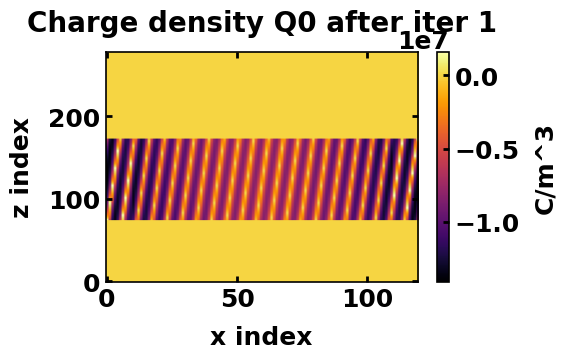

  Potential relative update: 1.002e+00
Iteration 2 (damping=0.55)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Q0 range: [-1.307e+07, 1.600e+06]


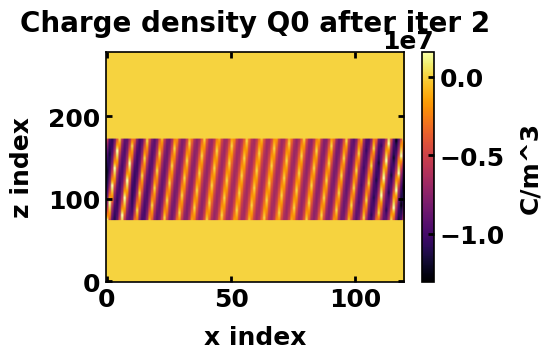

  Potential relative update: 2.453e-01
Iteration 3 (damping=0.61)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Q0 range: [-1.193e+07, 1.600e+06]


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

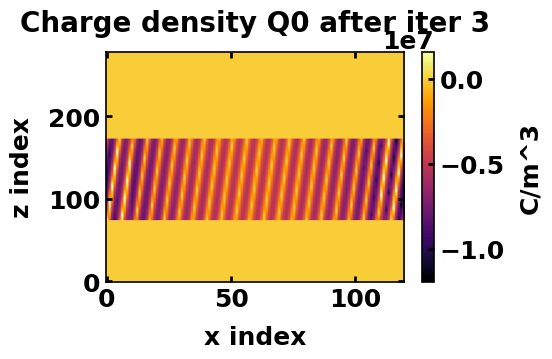

  Potential relative update: 2.616e-02
Did not converge in 3 iterations (final err=2.616e-02).


In [123]:
simulator = FEM_Simulator(device_params)

Vh, rho_h, epsilon_h = simulator.solve_device_state()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

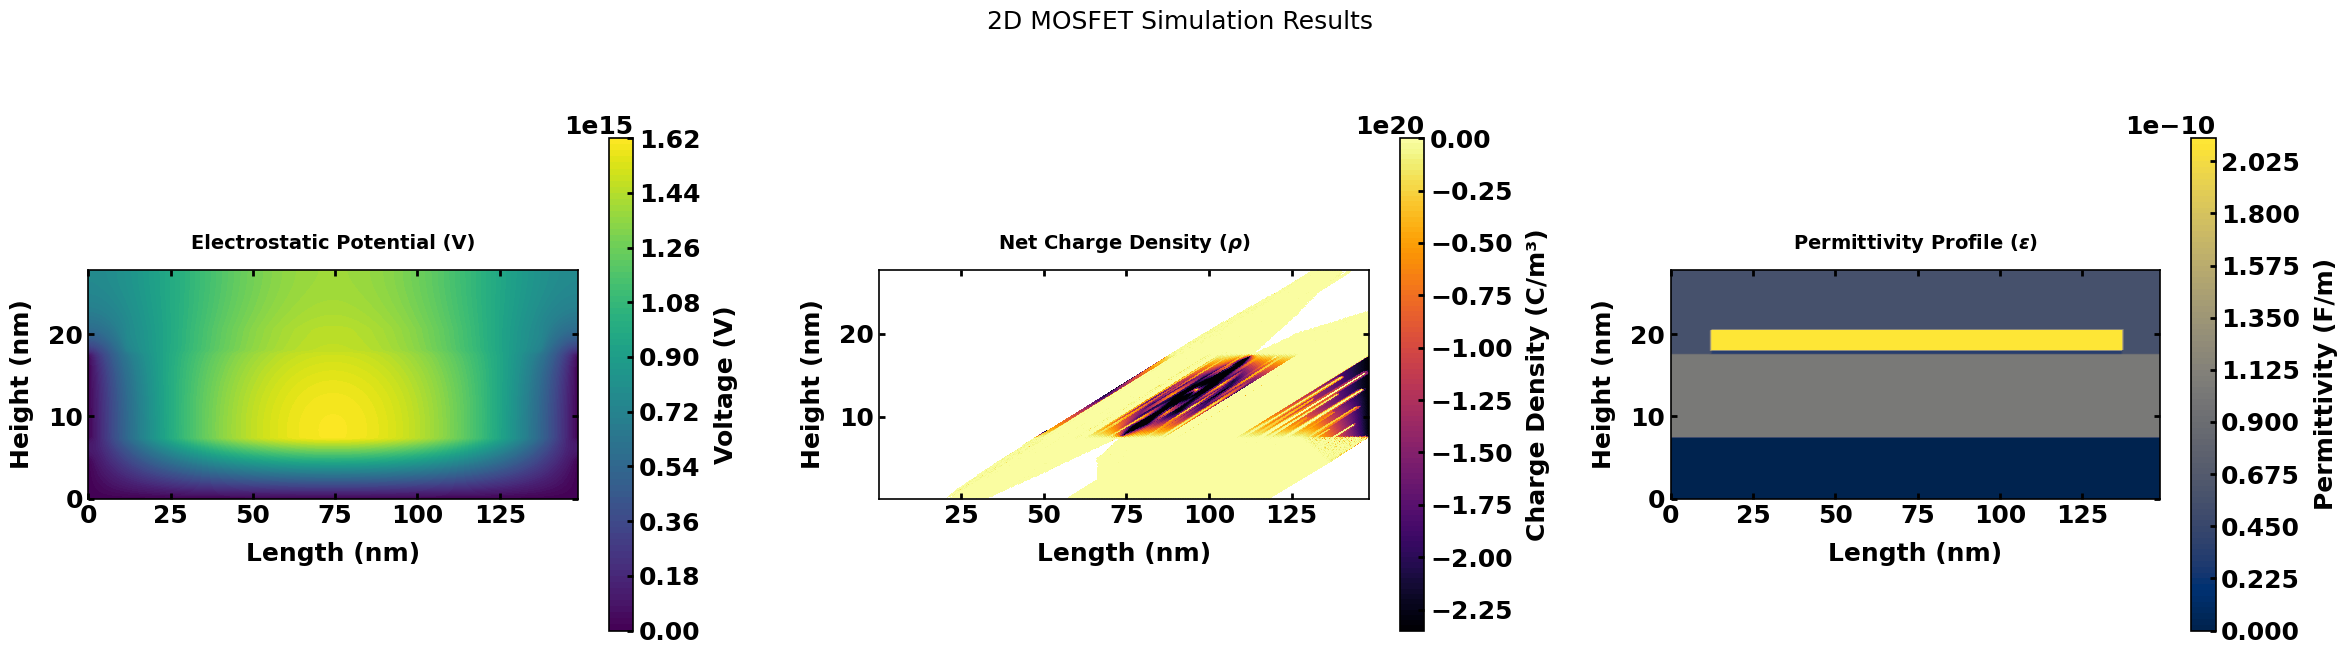

In [115]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import dolfinx
import numpy as np

def visualize_solution(Vh, rho_h, epsilon_h):
    """
    Creates detailed plots of the electrostatic potential, charge density,
    and permittivity from the FEniCSx simulation results.

    Args:
        Vh (dolfinx.fem.Function): The solved potential function.
        rho_h (dolfinx.fem.Function): The final charge density function.
        epsilon_h (dolfinx.fem.Function): The permittivity function.
    """
    if MPI.COMM_WORLD.rank == 0:
        # --- 1. Extract Data for Plotting ---
        V_space = Vh.function_space
        Q_space = rho_h.function_space
        mesh = V_space.mesh

        # Get DOF coordinates and mesh connectivity for an accurate triangulation
        coords = V_space.tabulate_dof_coordinates()
        x_coords = coords[:, 0]
        y_coords = coords[:, 1]
        
        # Get the triangles from the mesh topology
        cells = mesh.topology.connectivity(mesh.topology.dim, 0).array.reshape(-1, 3)
        triangulation = tri.Triangulation(x_coords, y_coords, triangles=cells)


        coords_2 = Q_space.tabulate_dof_coordinates()
        mesh_2 = Q_space.mesh
        x_coords_2 = coords_2[:, 0]
        y_coords_2 = coords_2[:, 1]
        
        # Get the triangles from the mesh topology
        cells_2 = mesh_2.topology.connectivity(mesh_2.topology.dim, 0).array.reshape(-1, 3)
        triangulation_2 = tri.Triangulation(x_coords_2, y_coords_2, triangles=cells_2)

        # --- 2. Create the Plots ---
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))
        fig.suptitle('2D MOSFET Simulation Results', fontsize=18)

        # Plot 1: Electrostatic Potential
        contour1 = ax1.tricontourf(triangulation, Vh.x.array, levels=100, cmap='viridis')
        fig.colorbar(contour1, ax=ax1, label='Voltage (V)')
        ax1.set_title("Electrostatic Potential (V)", fontsize=14)
        ax1.set_xlabel("Length (nm)")
        ax1.set_ylabel("Height (nm)")
        ax1.set_aspect('equal', adjustable='box')
        # Format ticks to show nanometers
        ax1.set_xticklabels([f'{x*1e9:.0f}' for x in ax1.get_xticks()])
        ax1.set_yticklabels([f'{y*1e9:.0f}' for y in ax1.get_yticks()])

        # Plot 2: Charge Density
        contour2 = ax2.tricontourf(triangulation_2, rho_h.x.array, levels=100, cmap='inferno')
        fig.colorbar(contour2, ax=ax2, label='Charge Density (C/m³)')
        ax2.set_title("Net Charge Density ($\\rho$)", fontsize=14)
        ax2.set_xlabel("Length (nm)")
        ax2.set_ylabel("Height (nm)")
        ax2.set_aspect('equal', adjustable='box')
        ax2.set_xticklabels([f'{x*1e9:.0f}' for x in ax2.get_xticks()])
        ax2.set_yticklabels([f'{y*1e9:.0f}' for y in ax2.get_yticks()])

        # Plot 3: Permittivity
        contour3 = ax3.tricontourf(triangulation, epsilon_h.x.array, levels=100, cmap='cividis')
        fig.colorbar(contour3, ax=ax3, label='Permittivity (F/m)')
        ax3.set_title("Permittivity Profile ($\\epsilon$)", fontsize=14)
        ax3.set_xlabel("Length (nm)")
        ax3.set_ylabel("Height (nm)")
        ax3.set_aspect('equal', adjustable='box')
        ax3.set_xticklabels([f'{x*1e9:.0f}' for x in ax3.get_xticks()])
        ax3.set_yticklabels([f'{y*1e9:.0f}' for y in ax3.get_yticks()])

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
visualize_solution(Vh, rho_h, epsilon_h)

****** Sparse_Matrix Iteration Cycle #0 Starts.
********* Sparse_Matrix Iteration Cycle #0 Ends.  Simulation Error: 0.5 

****** Sparse_Matrix Iteration Cycle #1 Starts.
********* Sparse_Matrix Iteration Cycle #0 Ends.  Simulation Error: 0.5 

****** Sparse_Matrix Iteration Cycle #1 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.26143536212446916 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.26143536212446916 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 0.1018638085390541 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 0.1018638085390541 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #3 Ends.  Simulation Error: 0.011731197108374667 

********* Sparse_Matrix Iteration Cycle #3 Ends.  Simulation Error:

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

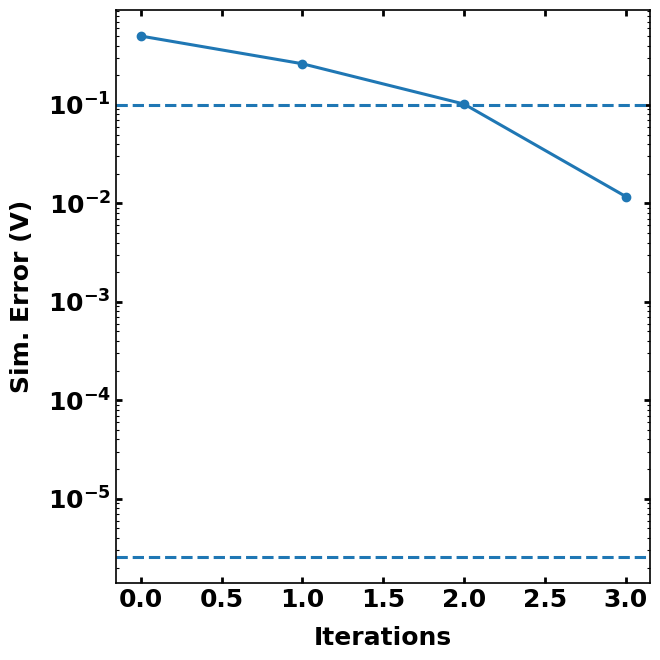

In [116]:
simulator = DeviceSimulator(device_params)
simulator.solve_device_state()

## Visualize the results

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

Is (uA/um) = -9.528055476019482e-05; Id (uA/um) = -9.528017326530821e-05


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

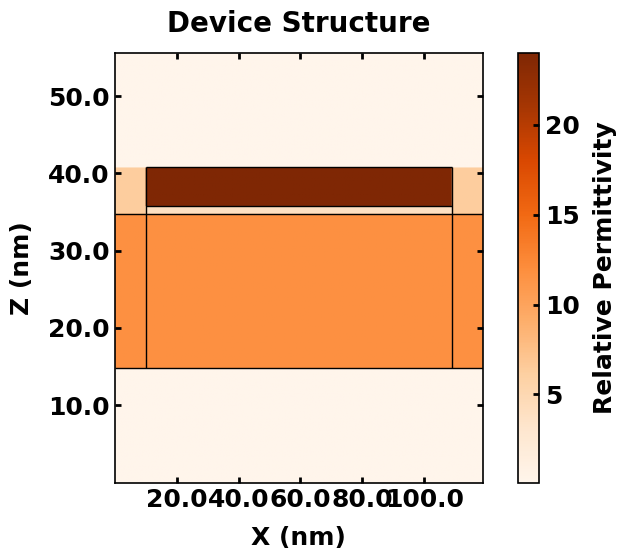

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

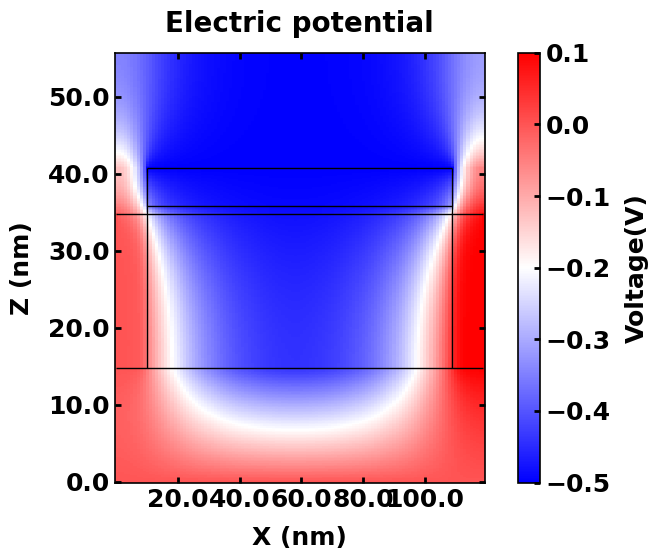

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

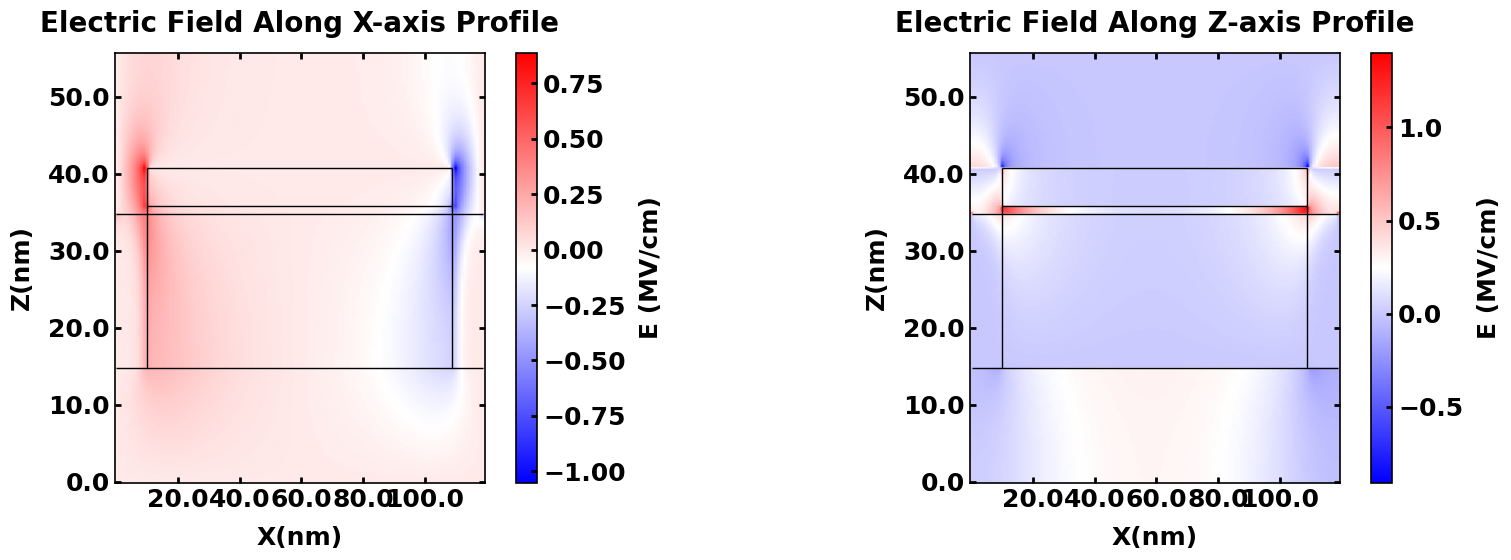

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

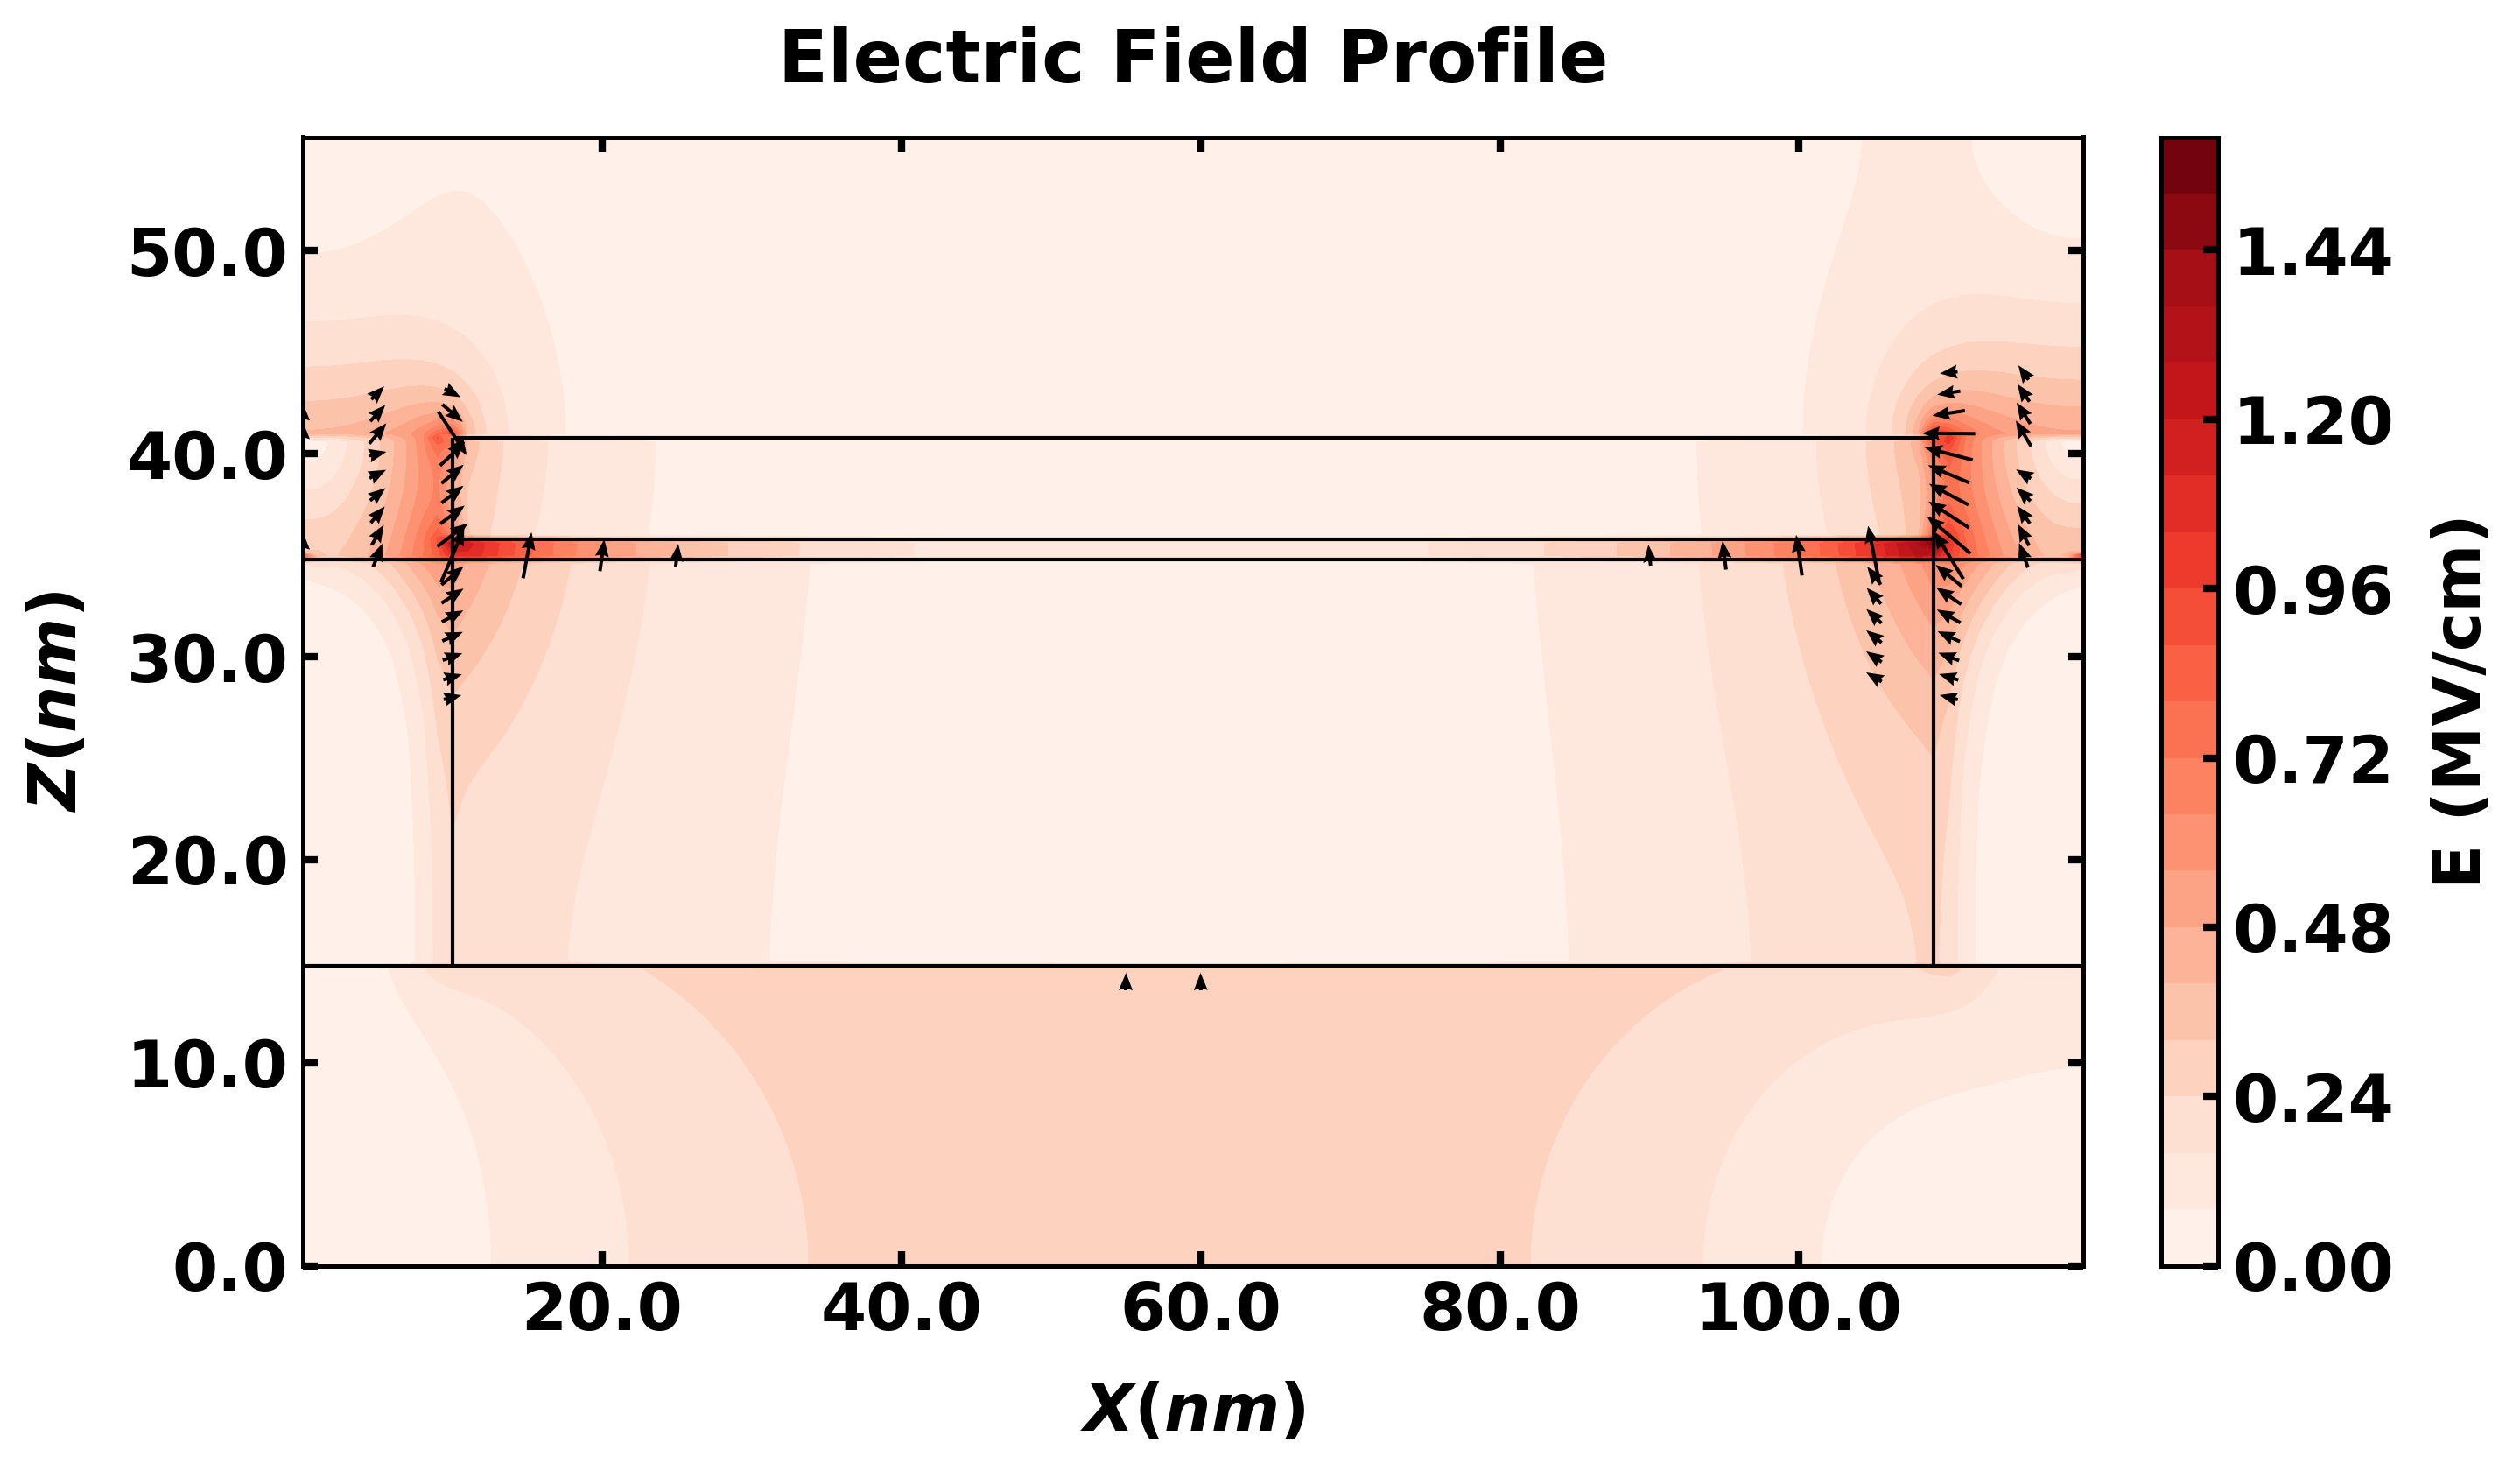

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

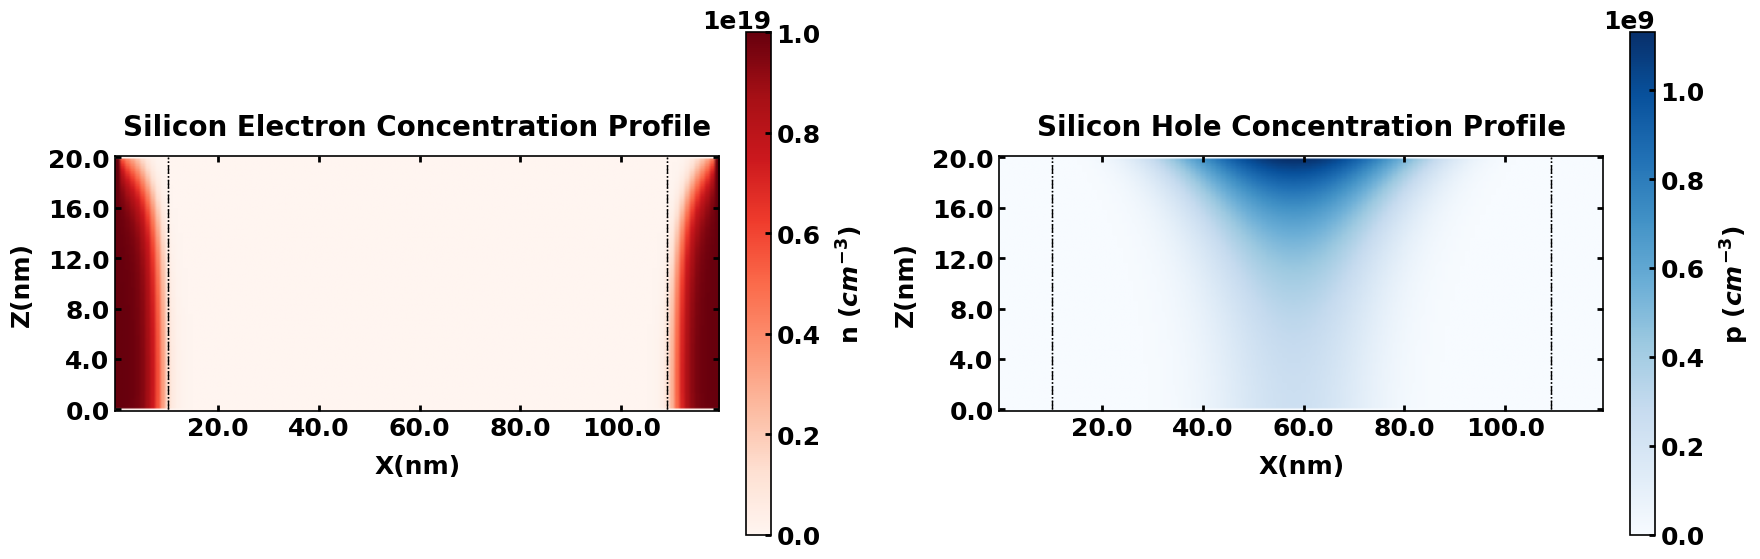

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

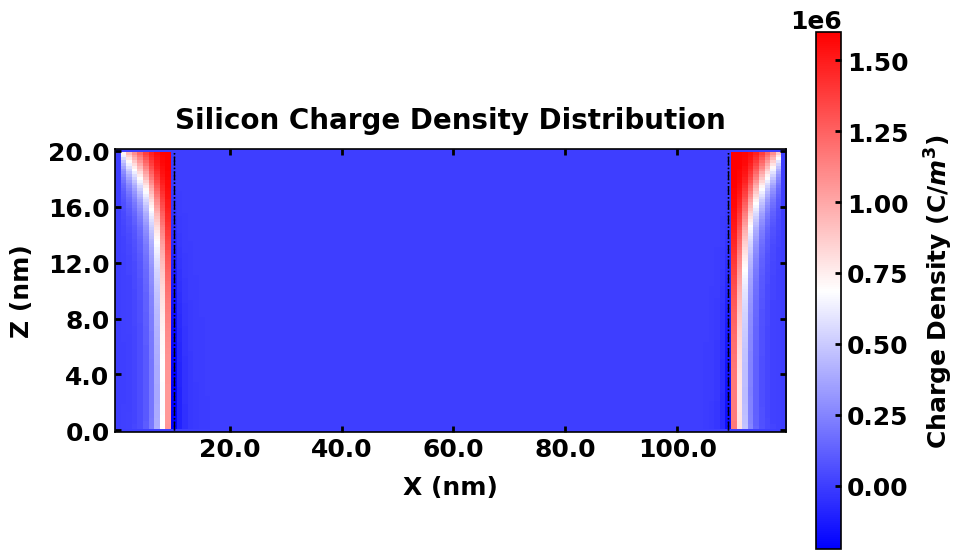

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

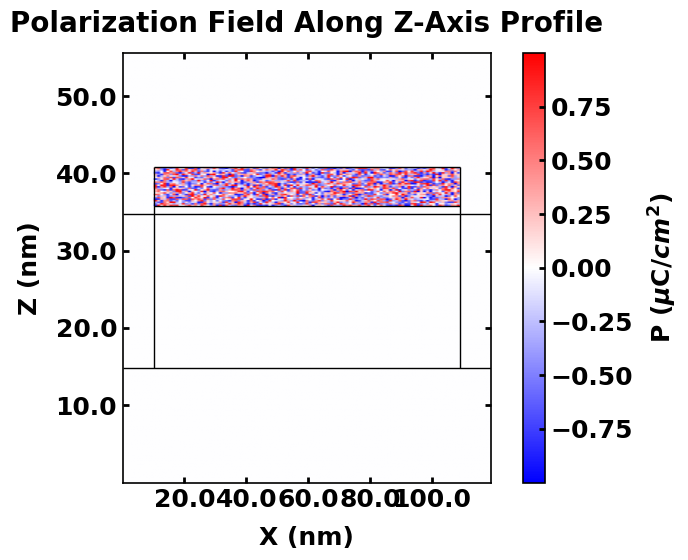

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

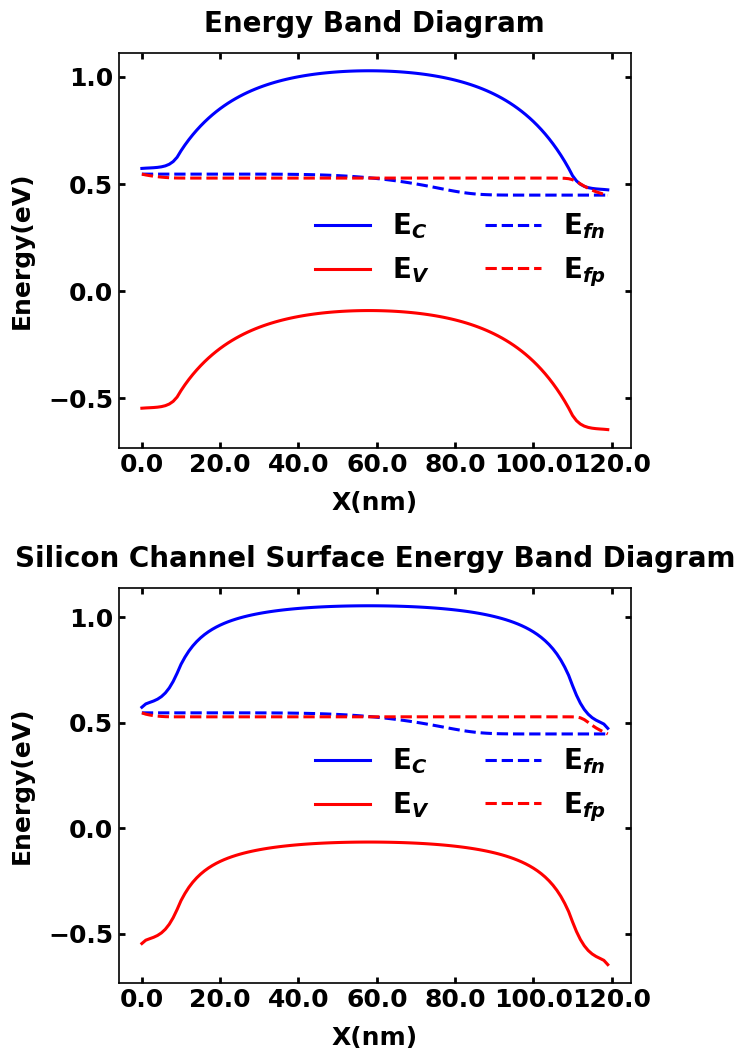

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

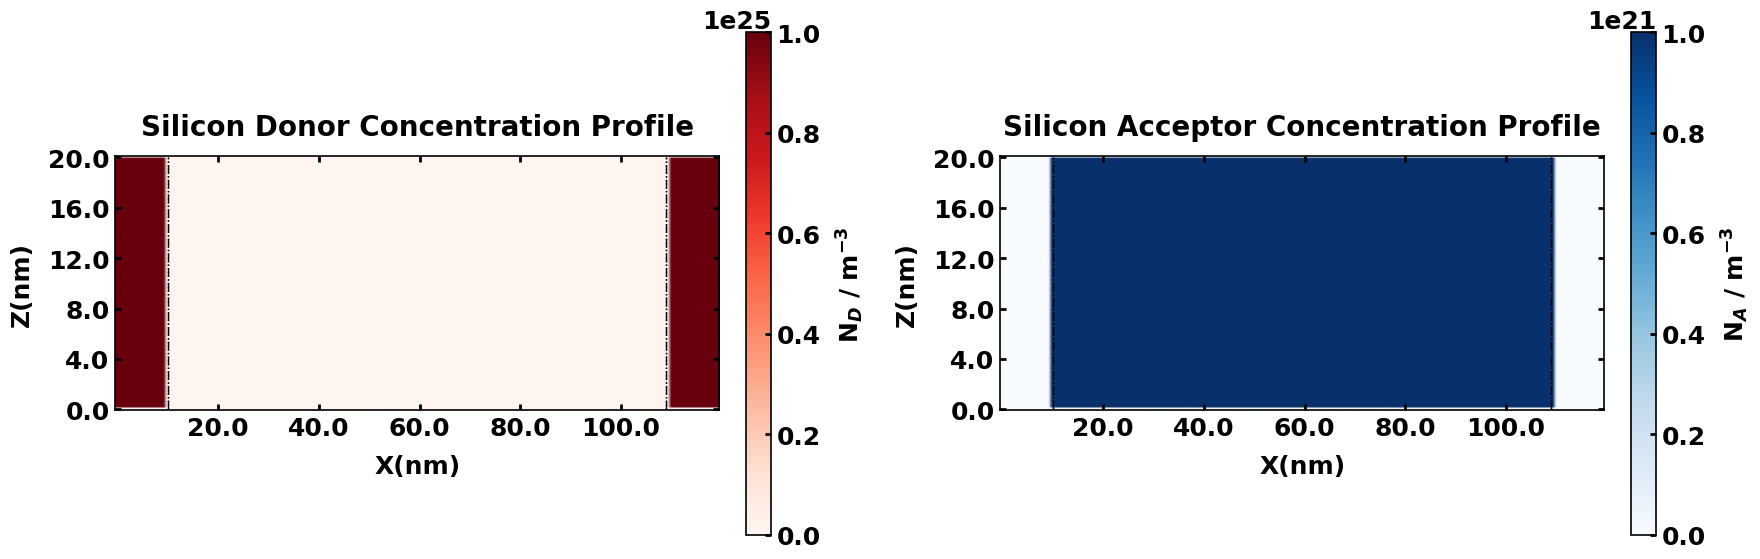

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

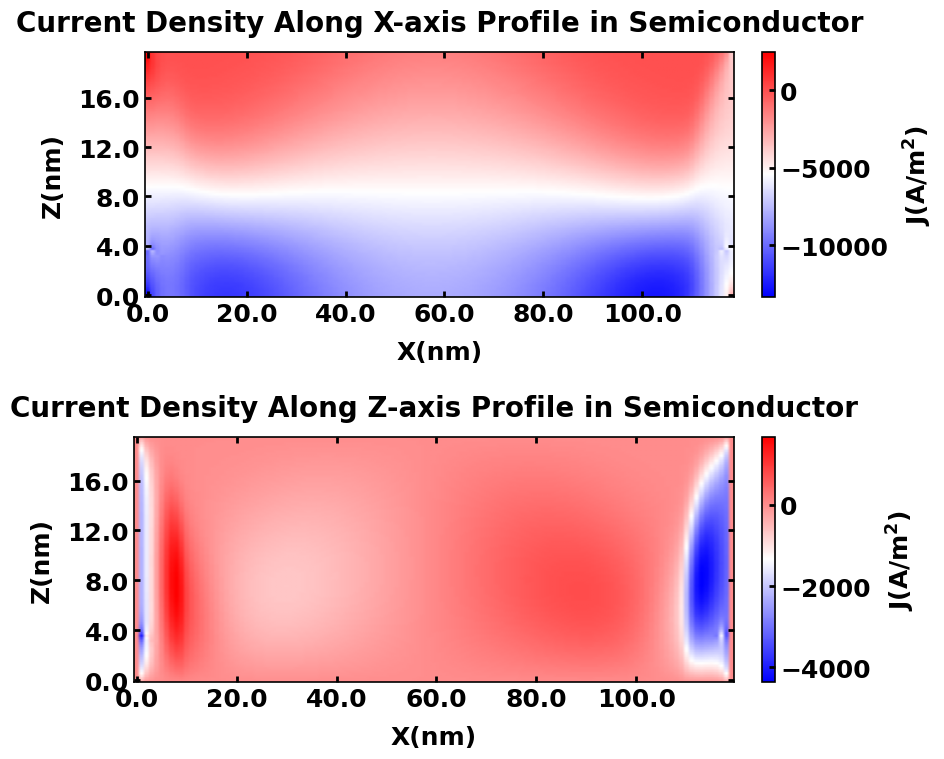

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

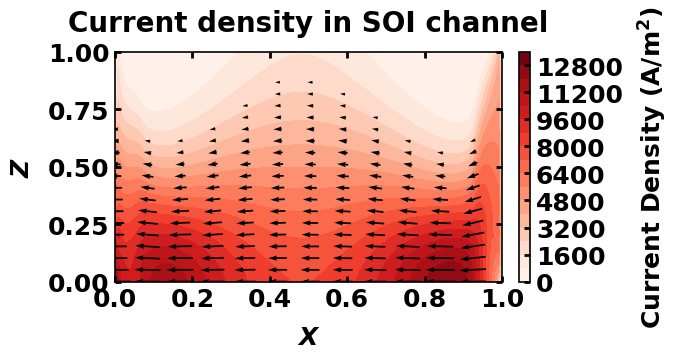

In [117]:
visualizer = DeviceVisualizer(device_params,aspect_ratio=0.5)
visualizer.visualize_permittivity(cmap='Oranges')
visualizer.plot_electric_potential(figsize=(10,6))
visualizer.plot_electric_field( vector_map = True)
visualizer.plot_carrier_concentration()
visualizer.plot_charge_density()
visualizer.plot_polarization_map()
visualizer.plot_energy_band_diagram()
visualizer.plot_dopant_concentration()
visualizer.plot_current_density_SG(vector_map = True)

## Id-Vg sweep

V_G:-0.900V V_D:0.050V
****** Sparse_Matrix Iteration Cycle #0 Starts.
********* Sparse_Matrix Iteration Cycle #0 Ends.  Simulation Error: 0.9 

****** Sparse_Matrix Iteration Cycle #1 Starts.
********* Sparse_Matrix Iteration Cycle #0 Ends.  Simulation Error: 0.9 

****** Sparse_Matrix Iteration Cycle #1 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.4295204934398642 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.4295204934398642 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 0.2679432568404628 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 0.2679432568404628 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #3 Ends.  Simulation Error: 0.15780062209684206 

********* Sparse_Matrix Iteration Cycle #3 Ends

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


****** Sparse_Matrix Iteration Cycle #1 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.056917331099039875 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.056917331099039875 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 4.121061937563955e-05 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 4.121061937563955e-05 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #3 Ends.  Simulation Error: 9.755869676857946e-05 

********* Sparse_Matrix Iteration Cycle #3 Ends.  Simulation Error: 9.755869676857946e-05 



findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


V_G:-0.800V V_D:0.050V
****** Update VG, initial electric potential guess sim. error: 0.09999999999999998
****** Sparse_Matrix Iteration Cycle #1 Starts.
****** Update VG, initial electric potential guess sim. error: 0.09999999999999998
****** Sparse_Matrix Iteration Cycle #1 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.0012193475414424605 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #1 Ends.  Simulation Error: 0.0012193475414424605 

****** Sparse_Matrix Iteration Cycle #2 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 1.0392510025100229e-05 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #2 Ends.  Simulation Error: 1.0392510025100229e-05 

****** Sparse_Matrix Iteration Cycle #3 Starts.
********* Sparse_Matrix Iteration Cycle #3 Ends.  Simulation Error: 8.251201464507717e-08 

********* Sparse_Matrix Iteration Cycle #3 Ends.  Simulation 

KeyboardInterrupt: 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

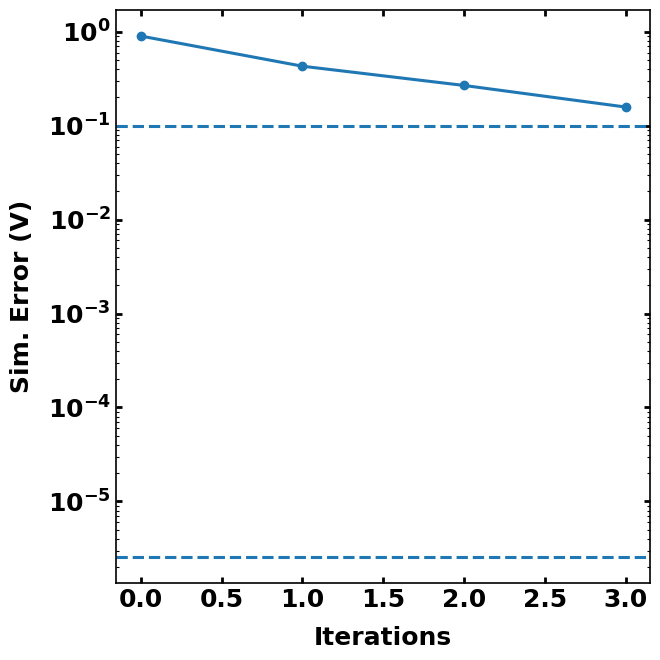

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

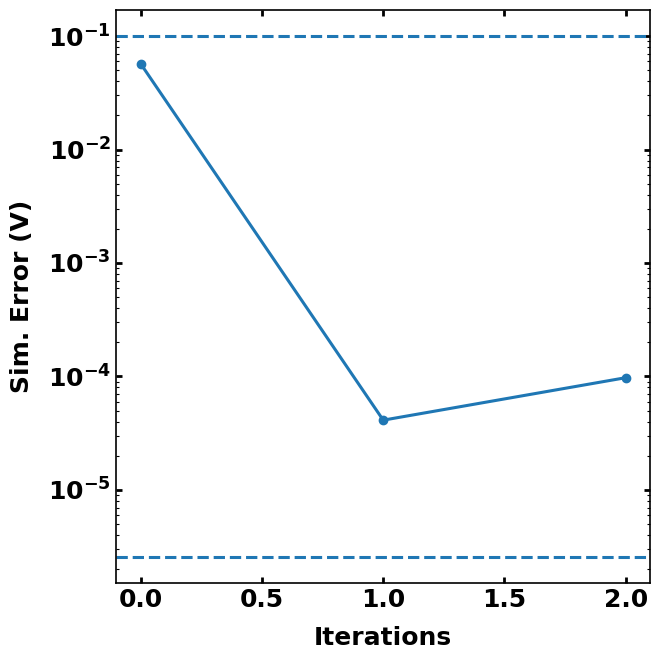

In [118]:
V_G_sweep = np.linspace(-0.9, 0.5, 15)
V_D_sweep = 0.05
I_D_sweep, I_S_sweep = simulator.ID_VG(V_D=V_D_sweep, V_G_arr=V_G_sweep)

In [ ]:
# V_G_sweep2 = np.linspace(-0.9, 0.5, 15)
# V_D_sweep2 = 1.0
# I_D_sweep2, I_S_sweep2 = simulator.ID_VG(V_D=V_D_sweep2, V_G_arr=V_G_sweep2)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

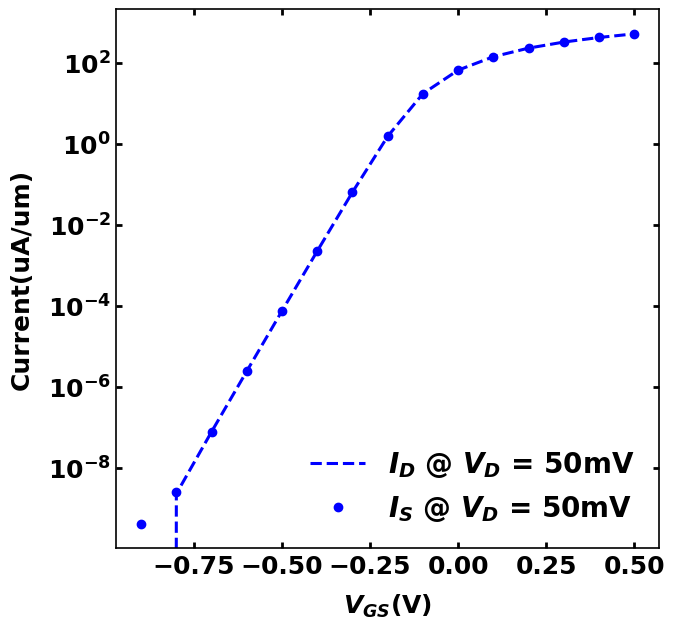

In [ ]:
plt.figure()
plt.plot(V_G_sweep, -I_D_sweep, 'b--', label = '$I_D$ @ $V_D$ = 50mV')
plt.plot(V_G_sweep, -I_S_sweep, 'bo', label = '$I_S$ @ $V_D$ = 50mV')

# plt.plot(V_G_sweep2, -I_D_sweep2, 'r--', label = '$I_D$ @ $V_D$ = 1V')
# plt.plot(V_G_sweep2, -I_S_sweep2, 'ro', label = '$I_S$ @ $V_D$ = 1V')
plt.legend()
plt.ylabel('Current(uA/um)')
plt.xlabel('$V_{GS}$(V)')
plt.yscale('log')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

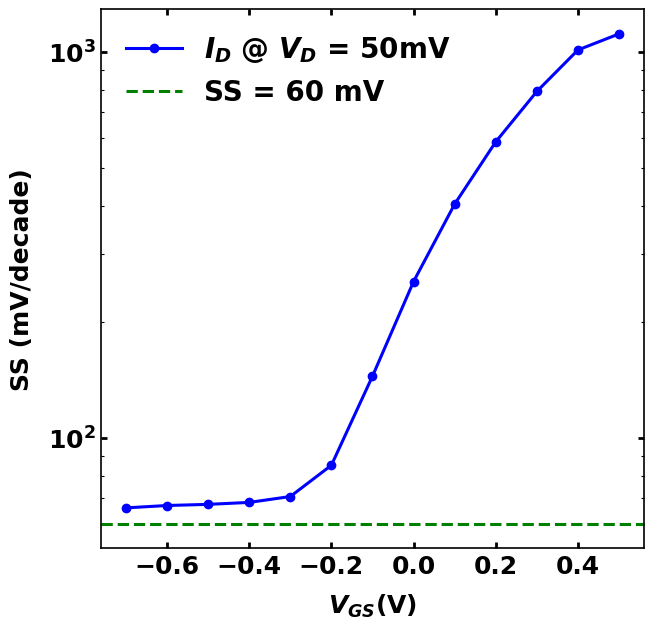

In [ ]:
plt.figure()
plt.plot(V_G_sweep, np.gradient(V_G_sweep, np.log10(-I_D_sweep)) *1e3, 'b-o', label = '$I_D$ @ $V_D$ = 50mV')
# plt.plot(V_G_sweep2, np.gradient(V_G_sweep2, np.log10(-I_D_sweep2)) *1e3, 'r-o', label = '$I_D$ @ $V_D$ = 1.0V')
plt.axhline(60 ,color= 'g', linestyle='--', label = 'SS = 60 mV')

plt.legend()
plt.ylabel('SS (mV/decade)')
plt.xlabel('$V_{GS}$(V)')
plt.yscale('log')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

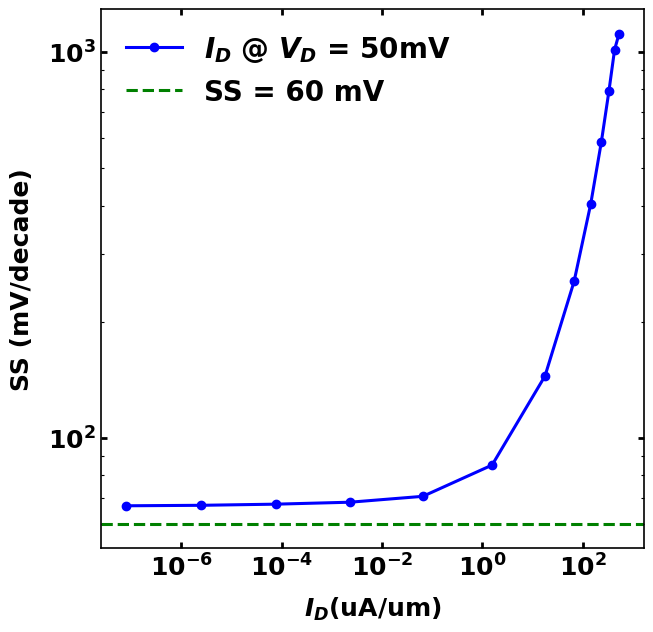

In [ ]:
plt.figure()
filtered_idx = -I_D_sweep>1e-8
plt.plot(-I_D_sweep[filtered_idx], np.gradient(V_G_sweep[filtered_idx], np.log10(-I_D_sweep[filtered_idx])) *1e3, 'b-o', label = '$I_D$ @ $V_D$ = 50mV')

# filtered_idx2 = -I_D_sweep2>1e-8
# plt.plot(-I_D_sweep2[filtered_idx2], np.gradient(V_G_sweep2[filtered_idx2], np.log10(-I_D_sweep2[filtered_idx2])) *1e3, 'r-o', label = '$I_D$ @ $V_D$ = 1.0V')

plt.axhline(60 ,color= 'g', linestyle='--', label = 'SS = 60 mV')

plt.legend()
plt.ylabel('SS (mV/decade)')
plt.xlabel('$I_{D}$(uA/um)')
plt.yscale('log')
plt.xscale('log')
plt.show()